In [2]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')

import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [4]:
# Import Dataset
df = pd.read_excel('C:/Forecasting/CocaCola_Sales_Rawdata.xlsx')
print('Shape of the data',df.shape)
df.head(10)

Shape of the data (42, 2)


Quarter        Sales
0   Q1_86  1734.827000
1   Q2_86  2244.960999
2   Q3_86  2533.804993
3   Q4_86  2154.962997
4   Q1_87  1547.818996
5   Q2_87  2104.411995
6   Q3_87  2014.362999
7   Q4_87  1991.746998
8   Q1_88  1869.049999
9   Q2_88  2313.631996

In [5]:
df.isnull().any()

Quarter    False
Sales      False
dtype: bool

In [6]:
df.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [7]:
df.shape

(42, 2)

In [8]:
#Checking the data types
df.dtypes

Quarter     object
Sales      float64
dtype: object

In [9]:
#Unique values for every feature
df.nunique()

Quarter    42
Sales      42
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 804.0+ bytes


In [11]:
df[df.duplicated()].shape

(0, 2)

In [12]:
df[df.duplicated()]

Empty DataFrame
Columns: [Quarter, Sales]
Index: []

In [13]:
df.describe()

Sales
count    42.000000
mean   2994.353308
std     977.930896
min    1547.818996
25%    2159.714247
50%    2782.376999
75%    3609.250000
max    5253.000000

Feature Engineering

In [14]:
df['Quarter_Year'] = df['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))
#Clean way to convert quarterly periods to datetime in pandas
df.head(10)

Quarter        Sales Quarter_Year
0   Q1_86  1734.827000      Q1 1986
1   Q2_86  2244.960999      Q2 1986
2   Q3_86  2533.804993      Q3 1986
3   Q4_86  2154.962997      Q4 1986
4   Q1_87  1547.818996      Q1 1987
5   Q2_87  2104.411995      Q2 1987
6   Q3_87  2014.362999      Q3 1987
7   Q4_87  1991.746998      Q4 1987
8   Q1_88  1869.049999      Q1 1988
9   Q2_88  2313.631996      Q2 1988

Coverting Quarter Years with Quarter Start Date Year (Date Month and Year)

In [15]:
# converting into datetime formate as the index was not in correct formate.
df['Date'] = (
    pd.to_datetime(
        df['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1]))
,dayfirst=True))
df.head(10)

Quarter        Sales Quarter_Year       Date
0   Q1_86  1734.827000      Q1 1986 1986-01-01
1   Q2_86  2244.960999      Q2 1986 1986-04-01
2   Q3_86  2533.804993      Q3 1986 1986-07-01
3   Q4_86  2154.962997      Q4 1986 1986-10-01
4   Q1_87  1547.818996      Q1 1987 1987-01-01
5   Q2_87  2104.411995      Q2 1987 1987-04-01
6   Q3_87  2014.362999      Q3 1987 1987-07-01
7   Q4_87  1991.746998      Q4 1987 1987-10-01
8   Q1_88  1869.049999      Q1 1988 1988-01-01
9   Q2_88  2313.631996      Q2 1988 1988-04-01

Extracting the Quarters and putting in column

In [16]:
df['Quarters'] = 0

for i in range(42):
    n = df['Quarter'][i]
    df['Quarters'][i] = n[0:2]
    
df.head(10)

Quarter        Sales Quarter_Year       Date Quarters
0   Q1_86  1734.827000      Q1 1986 1986-01-01       Q1
1   Q2_86  2244.960999      Q2 1986 1986-04-01       Q2
2   Q3_86  2533.804993      Q3 1986 1986-07-01       Q3
3   Q4_86  2154.962997      Q4 1986 1986-10-01       Q4
4   Q1_87  1547.818996      Q1 1987 1987-01-01       Q1
5   Q2_87  2104.411995      Q2 1987 1987-04-01       Q2
6   Q3_87  2014.362999      Q3 1987 1987-07-01       Q3
7   Q4_87  1991.746998      Q4 1987 1987-10-01       Q4
8   Q1_88  1869.049999      Q1 1988 1988-01-01       Q1
9   Q2_88  2313.631996      Q2 1988 1988-04-01       Q2

Creating Dummy Variables for Quarters Variable

In [17]:
dummy = pd.DataFrame(pd.get_dummies(df['Quarters']))
df1 = pd.concat((df, dummy), axis=1)

df1.head()

Quarter        Sales Quarter_Year       Date Quarters     Q1     Q2     Q3  \
0   Q1_86  1734.827000      Q1 1986 1986-01-01       Q1   True  False  False   
1   Q2_86  2244.960999      Q2 1986 1986-04-01       Q2  False   True  False   
2   Q3_86  2533.804993      Q3 1986 1986-07-01       Q3  False  False   True   
3   Q4_86  2154.962997      Q4 1986 1986-10-01       Q4  False  False  False   
4   Q1_87  1547.818996      Q1 1987 1987-01-01       Q1   True  False  False   

      Q4  
0  False  
1  False  
2  False  
3   True  
4  False

Dropping all the unnecessary column

In [18]:
df1.drop(['Quarter','Quarter_Year'] , axis =1, inplace = True)
df1.head()

Sales       Date Quarters     Q1     Q2     Q3     Q4
0  1734.827000 1986-01-01       Q1   True  False  False  False
1  2244.960999 1986-04-01       Q2  False   True  False  False
2  2533.804993 1986-07-01       Q3  False  False   True  False
3  2154.962997 1986-10-01       Q4  False  False  False   True
4  1547.818996 1987-01-01       Q1   True  False  False  False

Making the Date as DateTime index for the Dataframe

In [19]:
df1.set_index('Date',inplace=True)
df1.index.year

Index([1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988, 1988,
       1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991, 1991, 1991,
       1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994, 1994, 1994, 1994,
       1995, 1995, 1995, 1995, 1996, 1996],
      dtype='int32', name='Date')

In [20]:
df1.head()

Sales Quarters     Q1     Q2     Q3     Q4
Date                                                        
1986-01-01  1734.827000       Q1   True  False  False  False
1986-04-01  2244.960999       Q2  False   True  False  False
1986-07-01  2533.804993       Q3  False  False   True  False
1986-10-01  2154.962997       Q4  False  False  False   True
1987-01-01  1547.818996       Q1   True  False  False  False

Separating Month and Year into Separate Column for Visualization and removing meaningful insight of the data

In [21]:
df["Date"] = pd.to_datetime(df.Date,format="%b-%y")
df["month"] = df.Date.dt.strftime("%b") # month extraction
df["year"] = df.Date.dt.strftime("%Y") # year extraction
df.head(10)

Quarter        Sales Quarter_Year       Date Quarters month  year
0   Q1_86  1734.827000      Q1 1986 1986-01-01       Q1   Jan  1986
1   Q2_86  2244.960999      Q2 1986 1986-04-01       Q2   Apr  1986
2   Q3_86  2533.804993      Q3 1986 1986-07-01       Q3   Jul  1986
3   Q4_86  2154.962997      Q4 1986 1986-10-01       Q4   Oct  1986
4   Q1_87  1547.818996      Q1 1987 1987-01-01       Q1   Jan  1987
5   Q2_87  2104.411995      Q2 1987 1987-04-01       Q2   Apr  1987
6   Q3_87  2014.362999      Q3 1987 1987-07-01       Q3   Jul  1987
7   Q4_87  1991.746998      Q4 1987 1987-10-01       Q4   Oct  1987
8   Q1_88  1869.049999      Q1 1988 1988-01-01       Q1   Jan  1988
9   Q2_88  2313.631996      Q2 1988 1988-04-01       Q2   Apr  1988

Data Visualization

<Axes: xlabel='month', ylabel='year'>

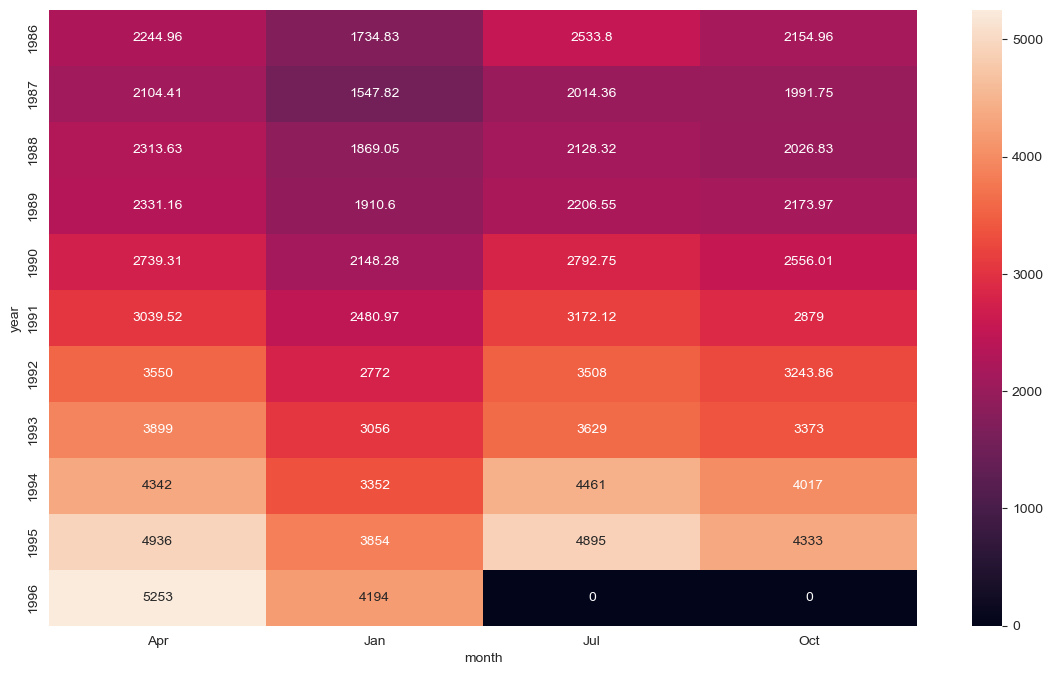

In [22]:
plt.figure(figsize=(14,8))
heatmap_y_month = pd.pivot_table(data=df,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") #fmt is format of the grid values

Line plot

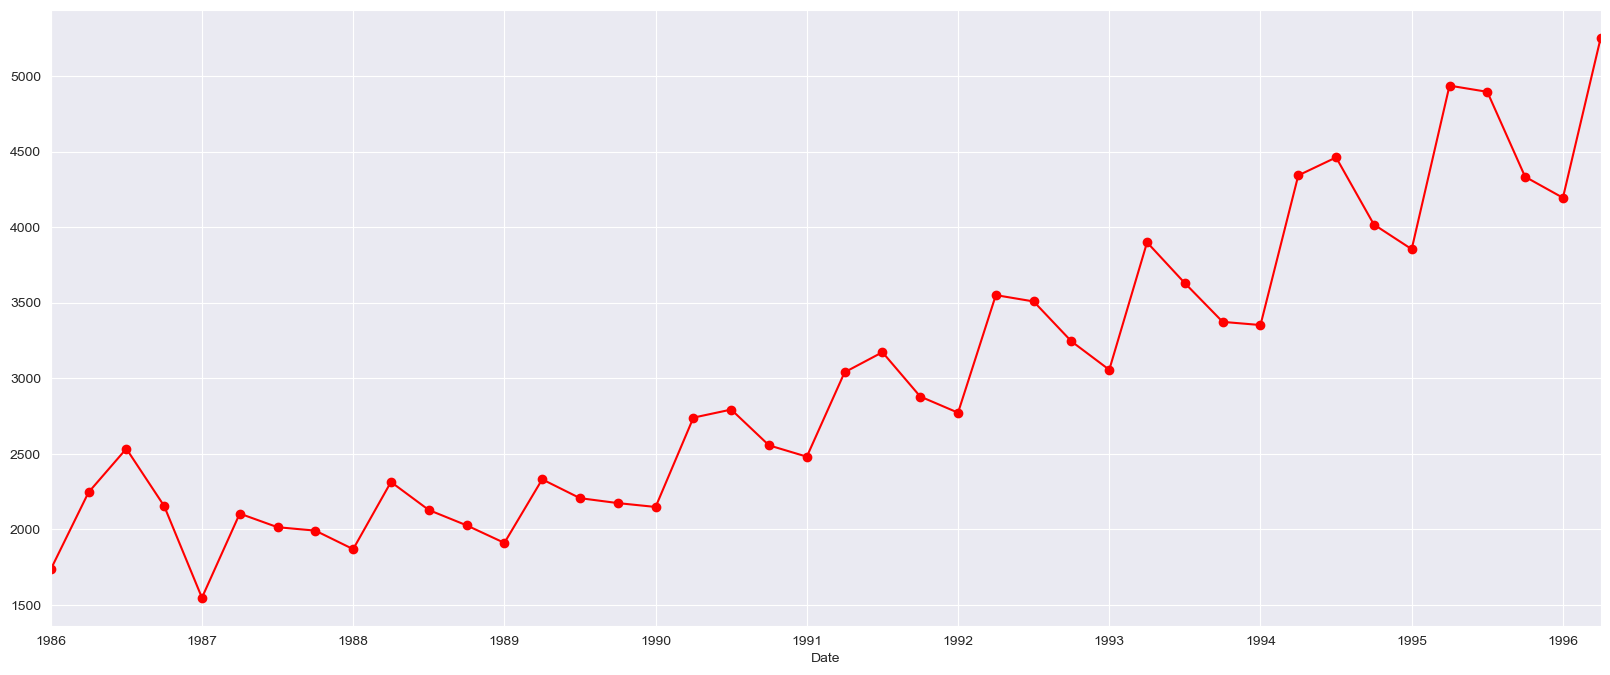

In [23]:
df1['Sales'].plot(figsize=(20, 8),color='red',marker='o')
plt.show()

Line Plot Using Quarters as Y axis and Sales as X axis

<Axes: xlabel='Quarters', ylabel='Sales'>

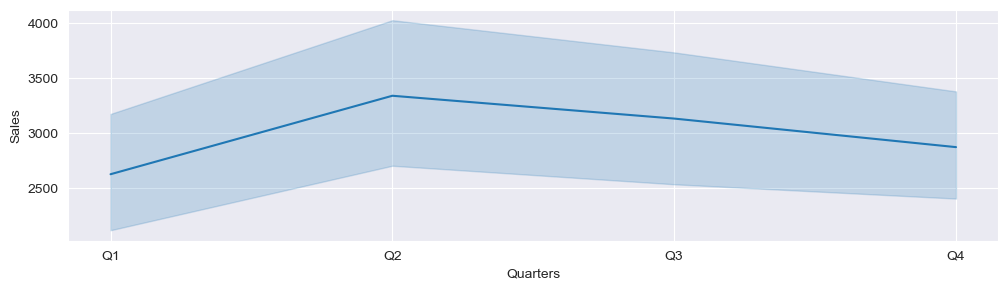

In [24]:
plt.figure(figsize=(12,3))
sns.lineplot(x="Quarters", y="Sales", data=df)

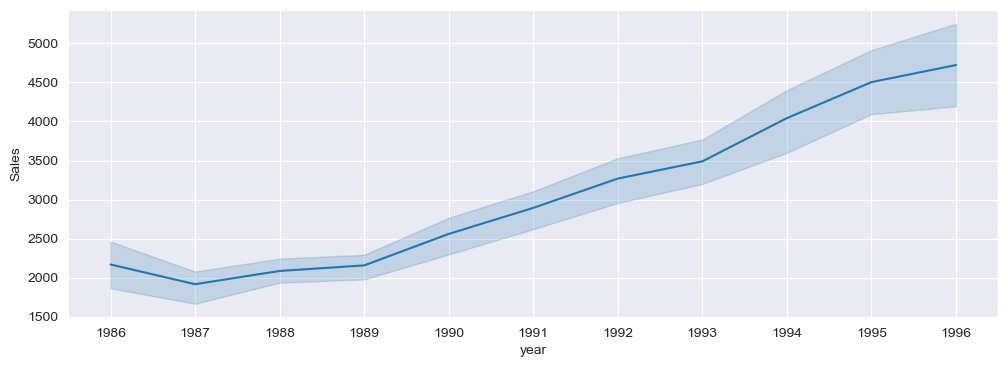

In [25]:
plt.figure(figsize=(12,4))
sns.lineplot(x="year",y="Sales",data=df)
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

Box Plot of Each Year by Quaterly Intervals

<Axes: xlabel='year', ylabel='Sales'>

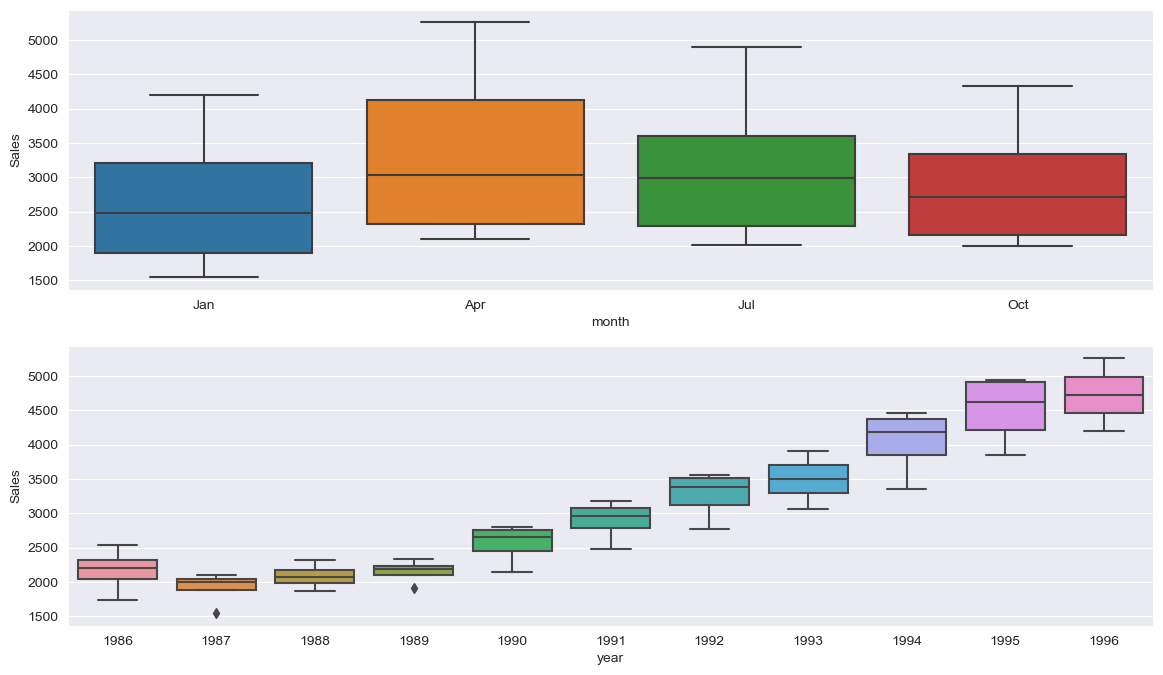

In [26]:
# Boxplot for ever
plt.figure(figsize=(14,8))
plt.subplot(211)
sns.boxplot(x="month",y="Sales",data=df)
plt.subplot(212)
sns.boxplot(x="year",y="Sales",data=df)

Histogram and Density Plots

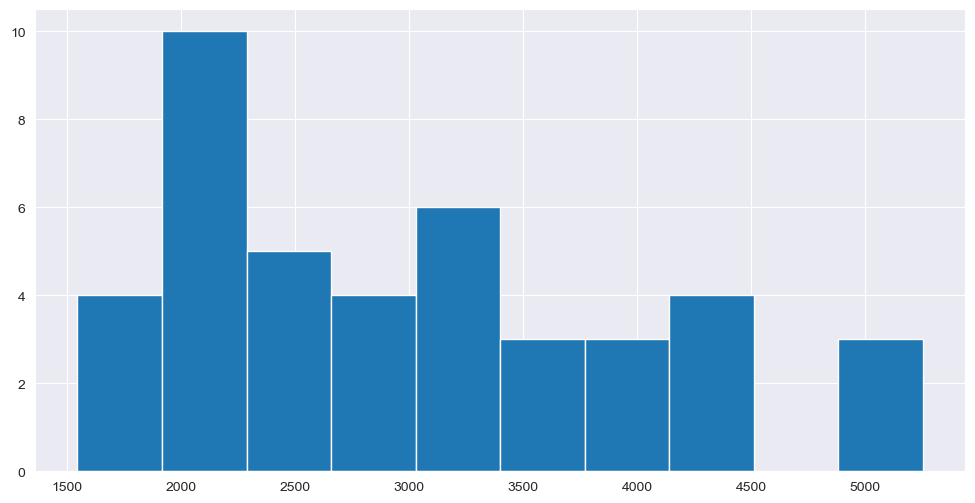

In [27]:
df.Sales.hist(figsize=(12,6))
plt.show()

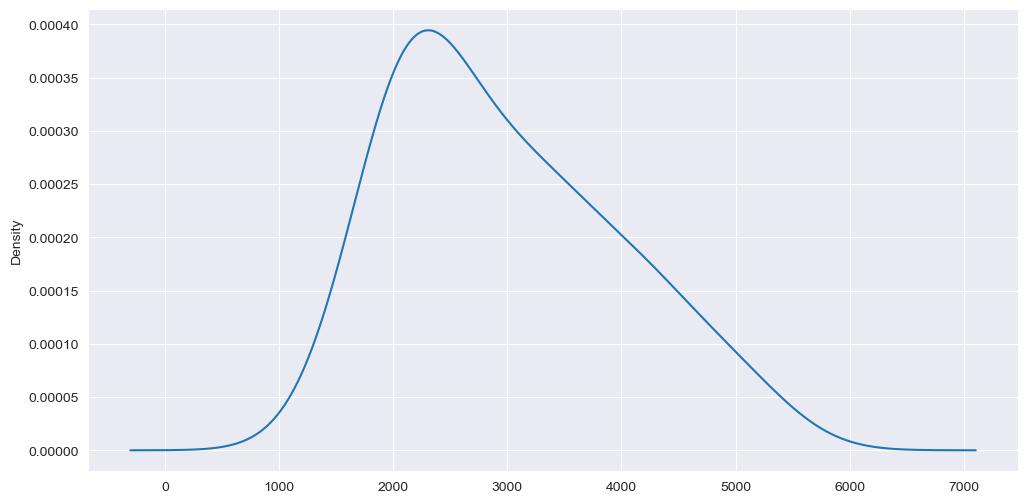

In [28]:
# create a density plot
df.Sales.plot(kind='kde', figsize=(12,6))
plt.show()

Lag plot

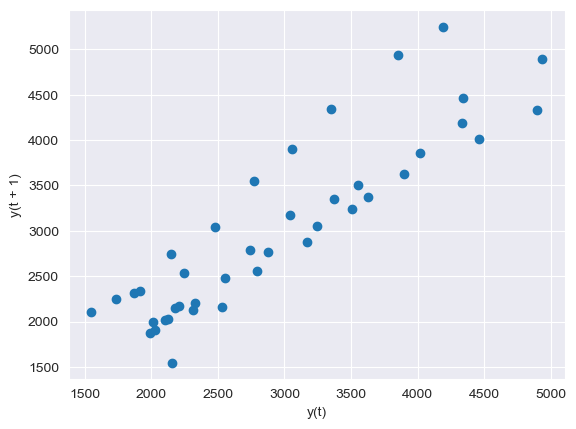

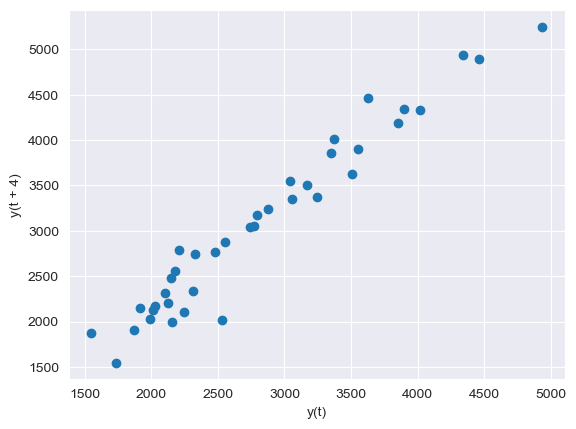

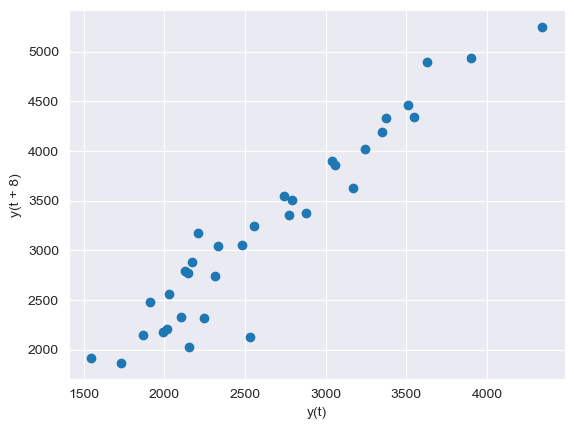

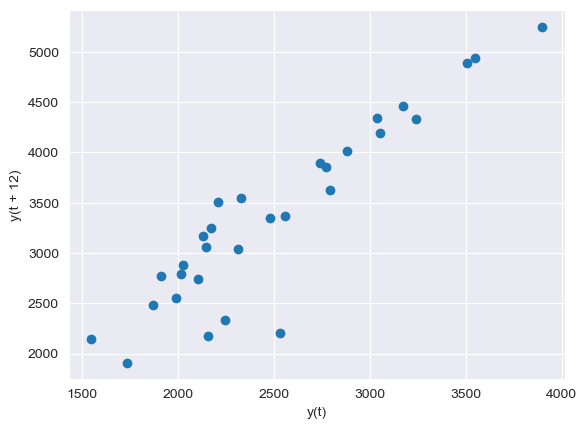

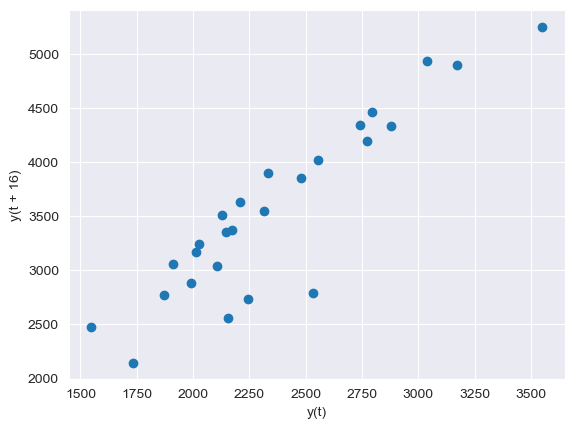

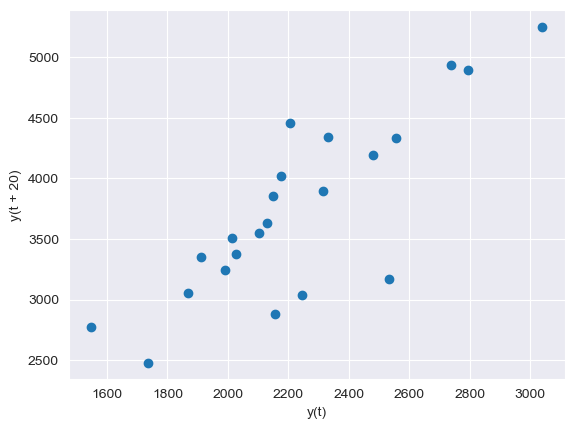

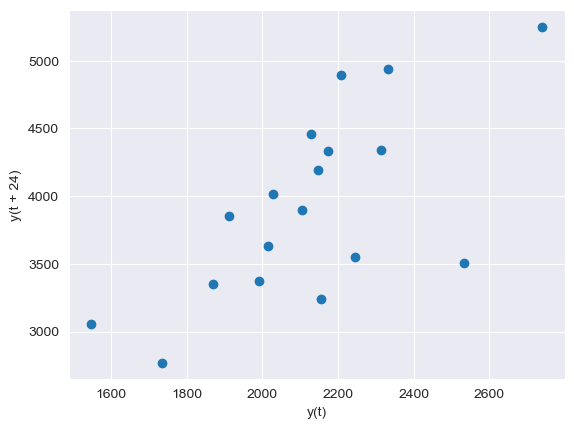

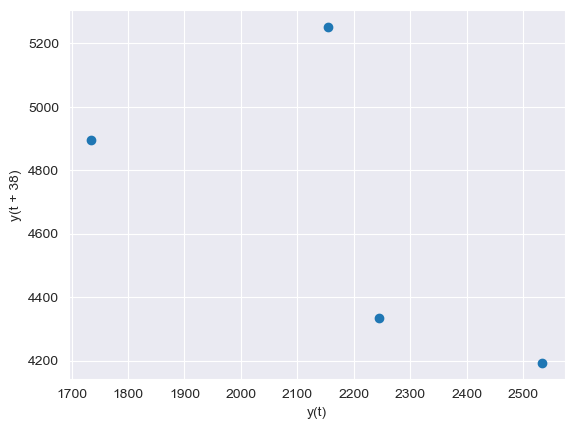

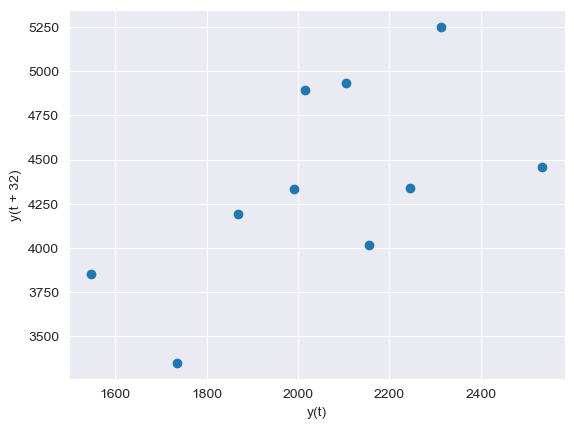

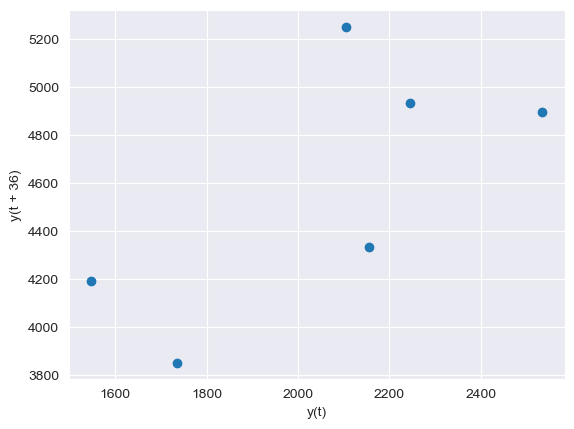

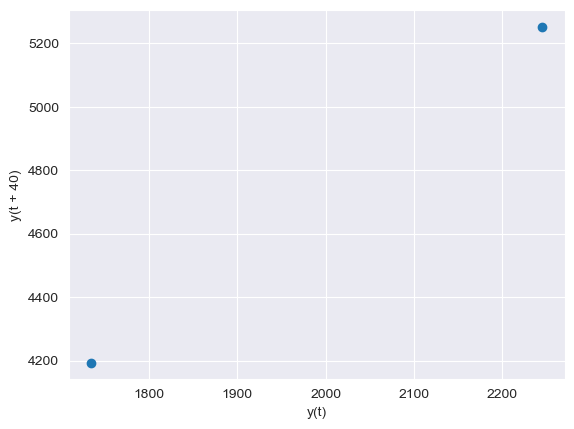

In [29]:
# create a scatter plot
for i in [1, 4, 8, 12, 16, 20, 24, 38, 32, 36, 40]:
    #plt.figure(figsize=(12,8))
    lag_plot(df.Sales, lag=i)
    plt.show()

Moving Average

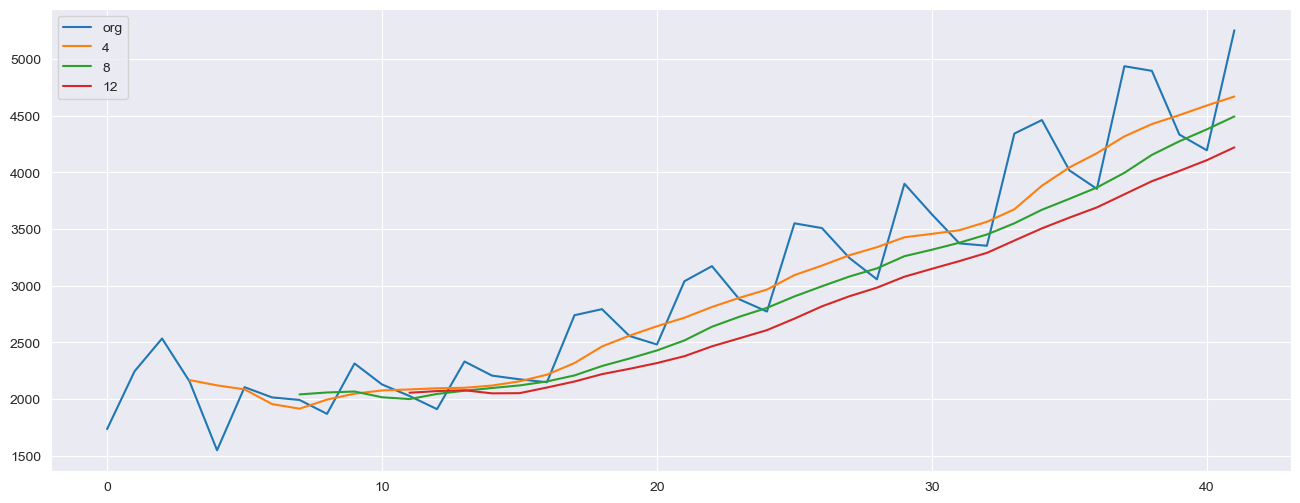

In [30]:
plt.figure(figsize=(16,6))
df.Sales.plot(label="org")
for i in range(4,13,4):
    df["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

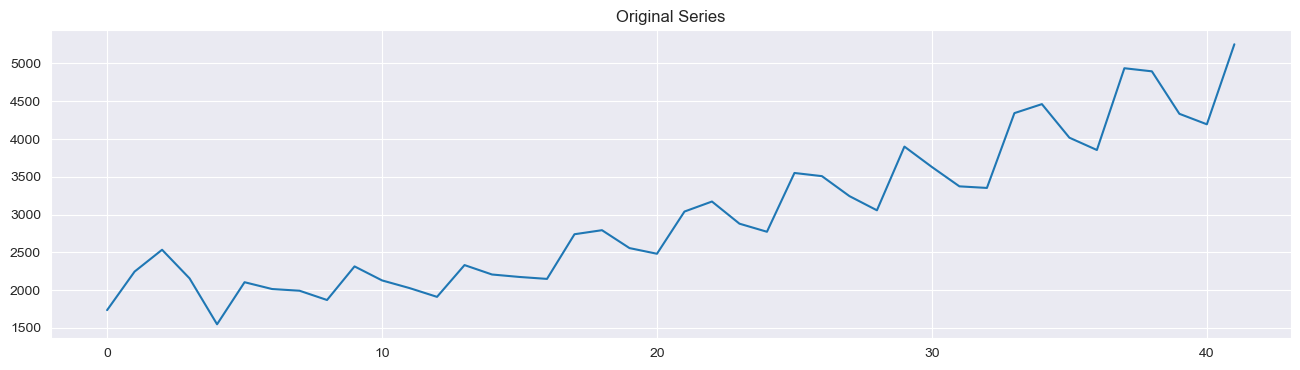

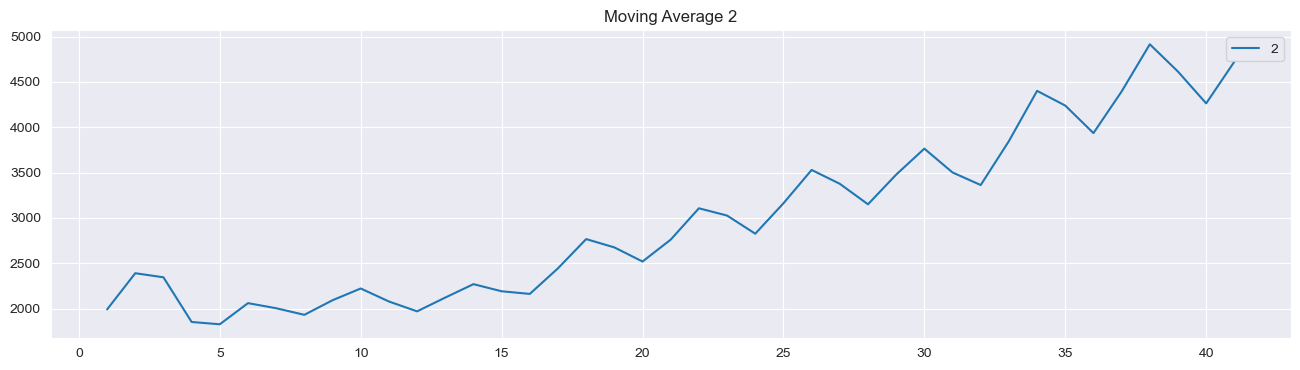

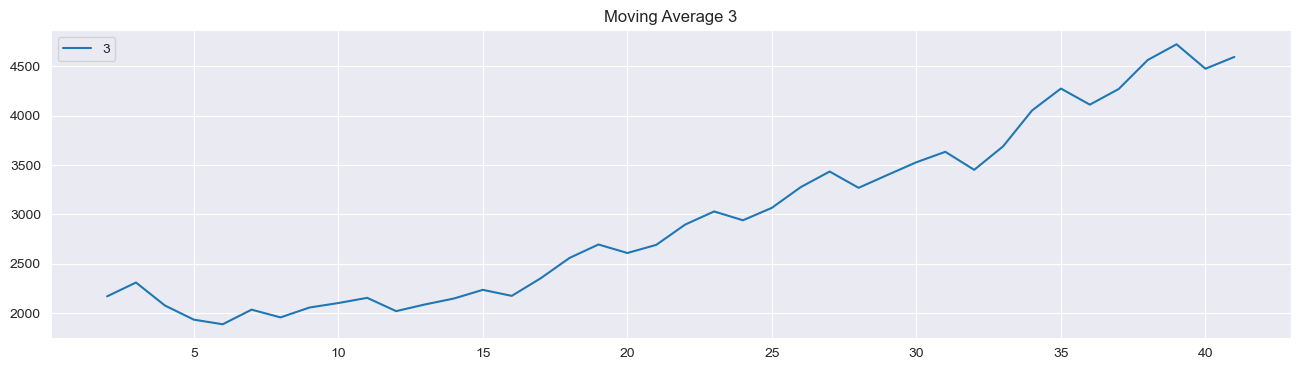

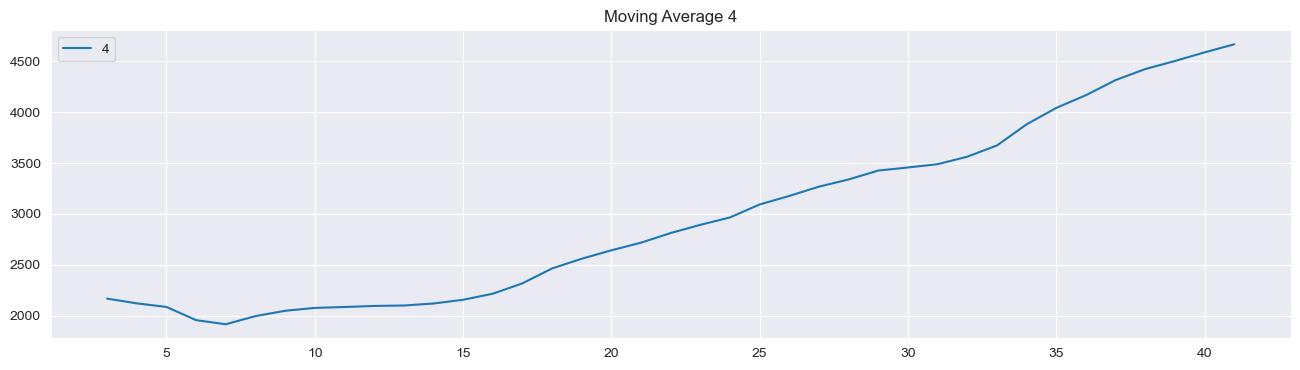

In [31]:
plt.figure(figsize=(16,4))
df.Sales.plot(label="org")
plt.title("Original Series")
for i in range(2,5):
    plt.figure(figsize=(16,4))
    df["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

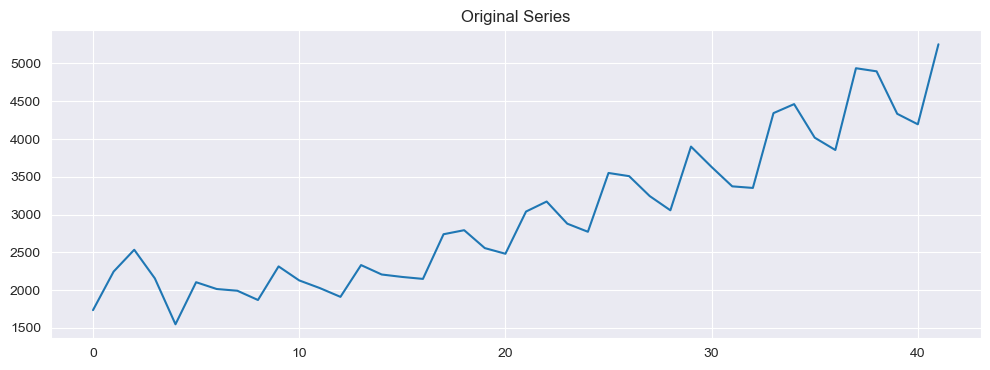

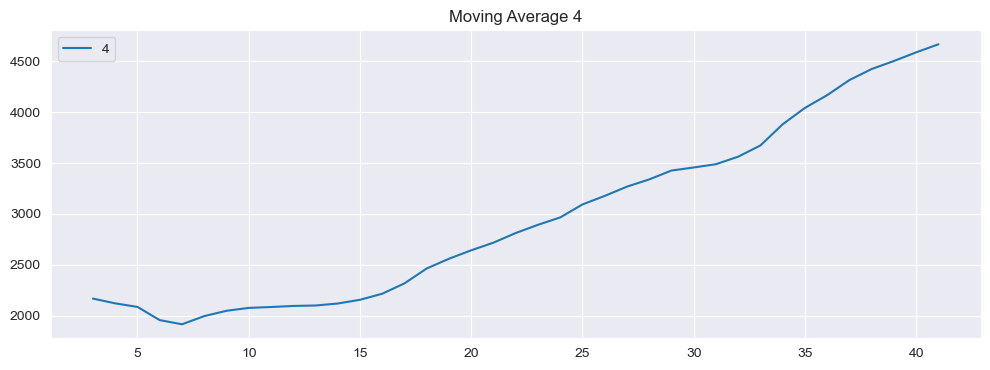

In [32]:
plt.figure(figsize=(12,4))
df.Sales.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(12,4))
df["Sales"].rolling(4).mean().plot(label=str(4))
plt.title("Moving Average "+str(4))
plt.legend(loc='best')
plt.show()

Time series decomposition plot

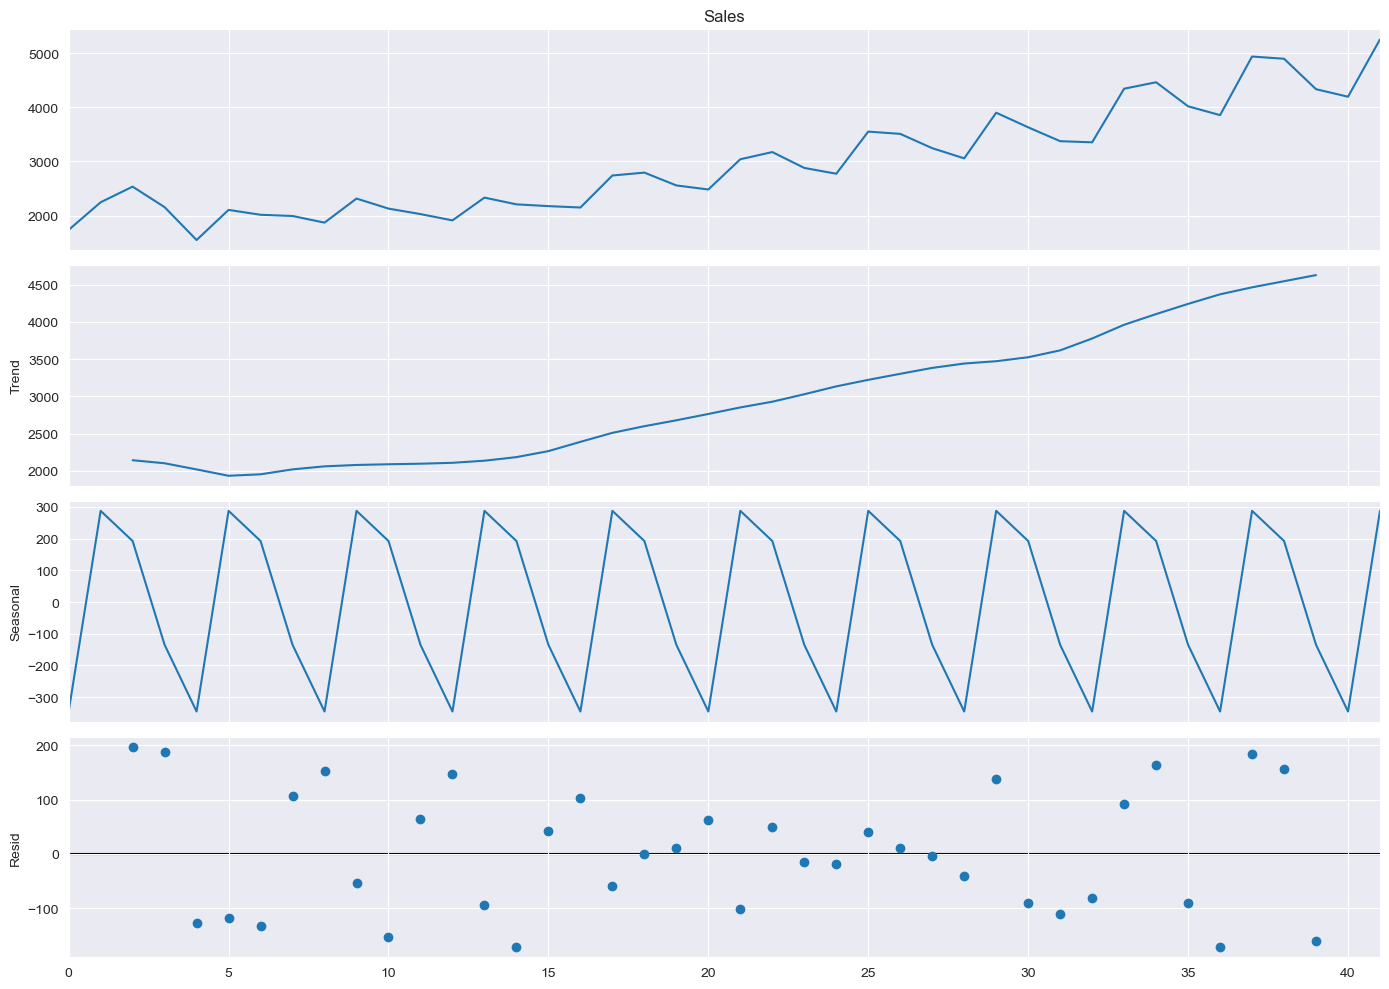

In [33]:
decompose_ts_add = seasonal_decompose(df.Sales,period=4)
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

# ACF plots and PACF plots

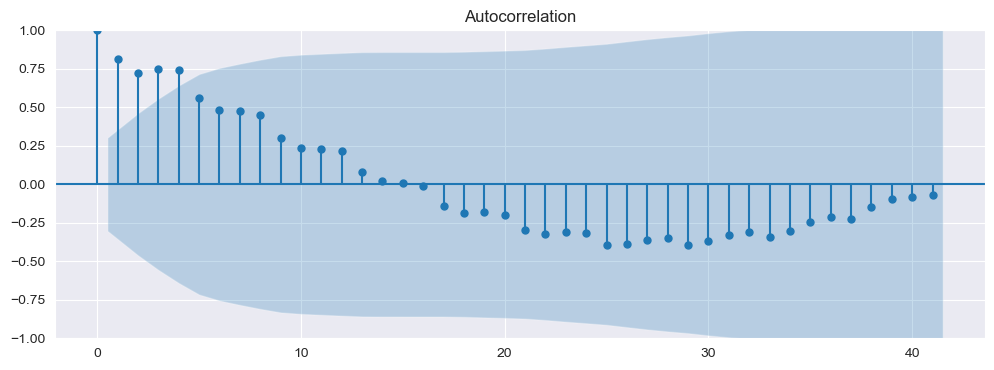

In [34]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_acf(df.Sales,lags=41)
    plt.show()

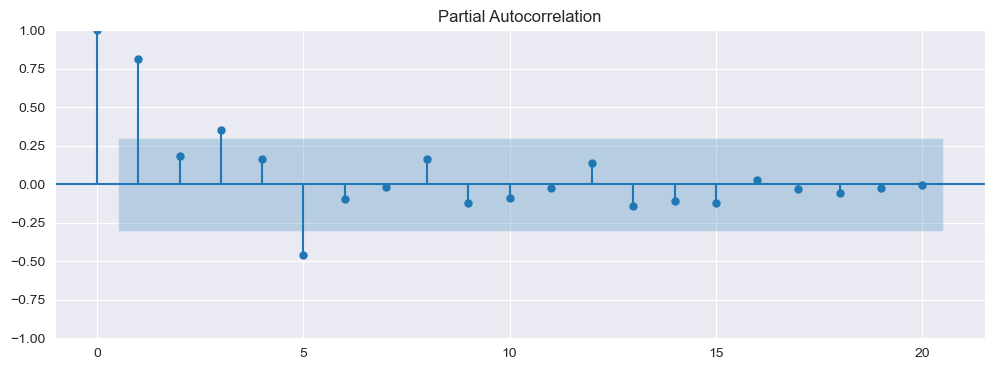

In [35]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_pacf(df.Sales,lags=20)
    plt.show()

To summarize, a partial autocorrelation function captures a “direct” correlation between time series and a lagged version of itself.

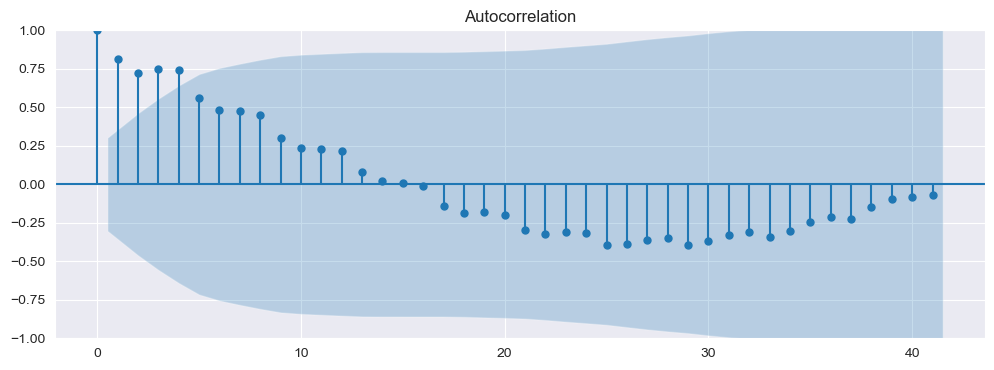

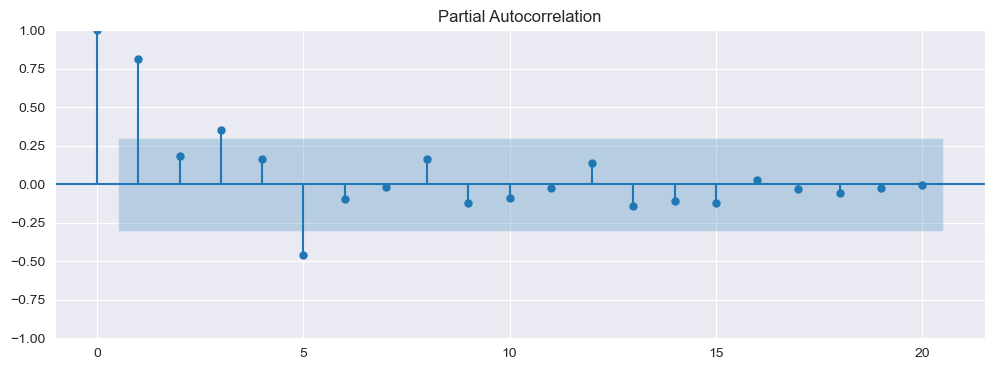

In [36]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_acf(df.Sales,lags=41)
    tsa_plots.plot_pacf(df.Sales,lags=20)
    plt.show()

upsampling with respect to month

In [37]:
upsampled_month = df1.drop(['Quarters','Q1','Q2','Q3','Q4'], axis=1)
upsampled_month = upsampled_month.resample('M').mean()
print(upsampled_month.head(13))

                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28          NaN
1986-03-31          NaN
1986-04-30  2244.960999
1986-05-31          NaN
1986-06-30          NaN
1986-07-31  2533.804993
1986-08-31          NaN
1986-09-30          NaN
1986-10-31  2154.962997
1986-11-30          NaN
1986-12-31          NaN
1987-01-31  1547.818996


                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330
1986-06-30  2437.523661
1986-07-31  2533.804993
1986-08-31  2407.524328
1986-09-30  2281.243663
1986-10-31  2154.962997
1986-11-30  1952.581664
1986-12-31  1750.200330
1987-01-31  1547.818996
1987-02-28  1733.349996
1987-03-31  1918.880995


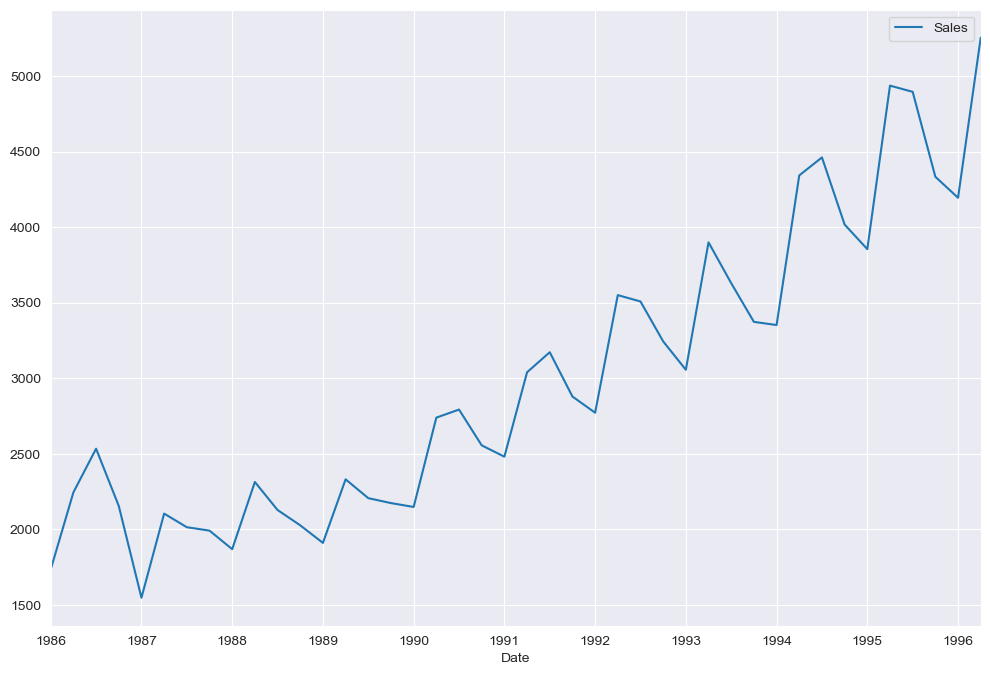

In [38]:
interpolated_month = upsampled_month.interpolate(method='linear') ## interplation was done for nan values which we get after doing upsampling by month
print(interpolated_month.head(15))
interpolated_month.plot(figsize=(12,8))
plt.show()

In [39]:
interpolated_month

Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330
...                 ...
1995-12-31  4240.333333
1996-01-31  4194.000000
1996-02-29  4547.000000
1996-03-31  4900.000000
1996-04-30  5253.000000

[124 rows x 1 columns]

In [40]:
visual = interpolated_month.copy()
visual.reset_index(inplace=True)
visual['date'] = pd.to_datetime(visual['Date'])
visual['year'] = visual['Date'].dt.year
visual['month'] = visual['Date'].dt.month
visual['week'] = visual['Date'].dt.isocalendar().week
visual['quarter'] = visual['Date'].dt.quarter
visual['day_of_week'] = visual['Date'].dt.day_name()
visual.drop('Date', axis =1 , inplace= True)
visual[:2]

Sales       date  year  month  week  quarter day_of_week
0  1734.827000 1986-01-31  1986      1     5        1      Friday
1  1904.871666 1986-02-28  1986      2     9        1      Friday

In [41]:
# data 
df_1986 = visual[visual['year']==1986][['month','Sales']]
df_1986 = df_1986.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1986'})
df_1987 = visual[visual['year']==1987][['month','Sales']]
df_1987 = df_1987.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1987'})
df_1988 = visual[visual['year']==1988][['month','Sales']]
df_1988 = df_1988.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1988'})
df_1989 = visual[visual['year']==1989][['month','Sales']]
df_1989 = df_1989.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1989'})
df_1990 = visual[visual['year']==1990][['month','Sales']]
df_1990 = df_1990.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1990'})
df_1991 = visual[visual['year']==1991][['month','Sales']]
df_1991 = df_1991.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1991'})
df_1992 = visual[visual['year']==1992][['month','Sales']]
df_1992 = df_1992.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1992'})
df_1993 = visual[visual['year']==1993][['month','Sales']]
df_1993 = df_1993.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1993'})
df_1994 = visual[visual['year']==1994][['month','Sales']]
df_1994 = df_1994.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1994'})
df_1995 = visual[visual['year']==1995][['month','Sales']]
df_1995 = df_1995.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1995'})

df_year = df_1986.merge(df_1987,on='month').merge(df_1988,on='month').merge(df_1989,on='month').merge(df_1990,on='month')\
.merge(df_1991,on='month').merge(df_1992,on='month').merge(df_1993,on='month').merge(df_1994,on='month').merge(df_1995,on='month')

# top levels
top_labels = ['1986', '1987', '1988', '1989', '1990','1991','1992','1993','1994','1995']

colors = ['rgb(6, 19, 14)', 'rgb(18, 58, 43)',
          'rgb(31, 97, 71)', 'rgb(43, 136, 100)',
          'rgb(55, 174, 129)','rgb(81, 200, 154)',
          'rgb(119, 212, 176)','rgb(158, 224, 199)'
          ,'rgb(197, 237, 221)','rgb(236, 249, 244)']

# X axis value 
df_year = df_year[['1986', '1987', '1988', '1989', '1990','1991','1992','1993','1994','1995']].replace(np.nan,0)
x_data = df_year.values

# y axis value (Month)
df_1986['month'] =['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
y_data = df_1986['month'].tolist()

fig = go.Figure()
for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))

        
fig.update_layout(title='Avg Sales for each Year',
    xaxis=dict(showgrid=False, 
               zeroline=False, domain=[0.15, 1]),
    yaxis=dict(showgrid=False, showline=False,
               showticklabels=False, zeroline=False),
    barmode='stack', 
    template="plotly_white",
    margin=dict(l=0, r=50, t=100, b=10),
    showlegend=False, 
)

annotations = []
for yd, xd in zip(y_data, x_data):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=14,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=14,
                                          color='rgb(67, 67, 67)'),
                          showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=14,
                                                  color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]
fig.update_layout(
    annotations=annotations)
fig.show()

In [42]:
# data
import calendar
df_m_sa = visual.groupby('month').agg({"Sales" : "mean"}).reset_index()
df_m_sa['Sales'] = round(df_m_sa['Sales'],2)
df_m_sa['month_text'] = df_m_sa['month'].apply(lambda x: calendar.month_abbr[x])
df_m_sa['text'] = df_m_sa['month_text'] + ' - ' + df_m_sa['Sales'].astype(str) 

df_w_sa = visual.groupby('week').agg({"Sales" : "mean"}).reset_index() 
df_q_sa = visual.groupby('quarter').agg({"Sales" : "mean"}).reset_index() 
# chart color
df_m_sa['color'] = '#496595'
df_m_sa['color'][:-1] = '#c6ccd8'
df_w_sa['color'] = '#c6ccd8'

# chart
fig = make_subplots(rows=2, cols=2, vertical_spacing=0.08,
                    row_heights=[0.7, 0.3], 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3],
                    subplot_titles=("Month wise Avg Sales Analysis", "Quarter wise Avg Sales Analysis", 
                                    "Week wise Avg Sales Analysis"))

fig.add_trace(go.Bar(x=df_m_sa['Sales'], y=df_m_sa['month'], marker=dict(color= df_m_sa['color']),
                     text=df_m_sa['text'],textposition='auto',
                     name='Month', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_q_sa['Sales'], labels=df_q_sa['quarter'], name='Quarter',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label+percent'), 
                     row=1, col=2)
fig.add_trace(go.Scatter(x=df_w_sa['week'], y=df_w_sa['Sales'], mode='lines+markers', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#496595'), name='Week'), 
                     row=2, col=1)

# styling
fig.update_yaxes(visible=False, row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_w_sa.week, ticktext=[i for i in range(1,53)], 
                 row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=750, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

In [43]:
# data
df_dw_sa = visual.groupby('day_of_week').agg({"Sales" : "mean"}).reset_index()
df_dw_sa.Sales = round(df_dw_sa.Sales, 2)

# chart
fig = px.bar(df_dw_sa, y='day_of_week', x='Sales', title='Avg Sales vs Day of Week',
             color_discrete_sequence=['#c6ccd8'], text='Sales',
             category_orders=dict(day_of_week=["Monday","Tuesday","Wednesday","Thursday", "Friday","Saturday","Sunday"]))
fig.update_yaxes(showgrid=False, ticksuffix=' ', showline=False)
fig.update_xaxes(visible=False)
fig.update_layout(margin=dict(t=60, b=0, l=0, r=0), height=350,
                  hovermode="y unified", 
                  yaxis_title=" ", template='plotly_white',
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#c6ccd8", font_size=13, font_family="Lato, sans-serif"))

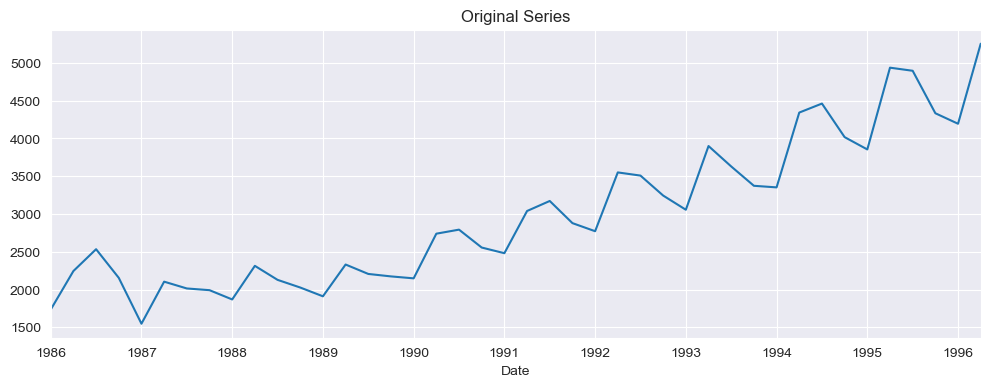

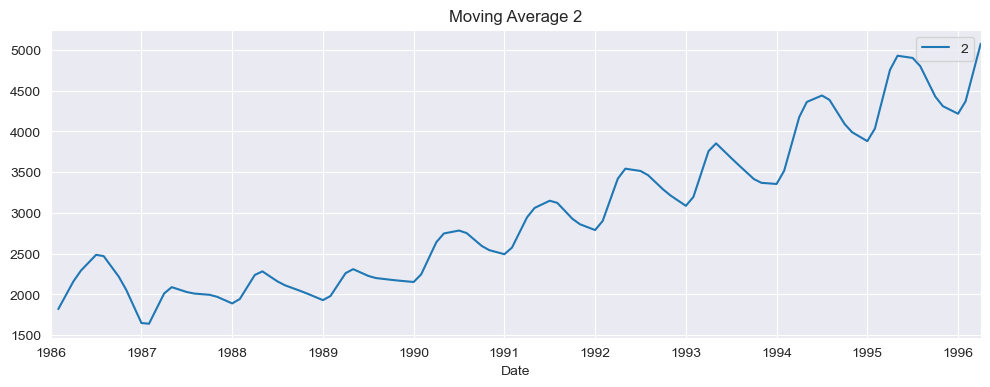

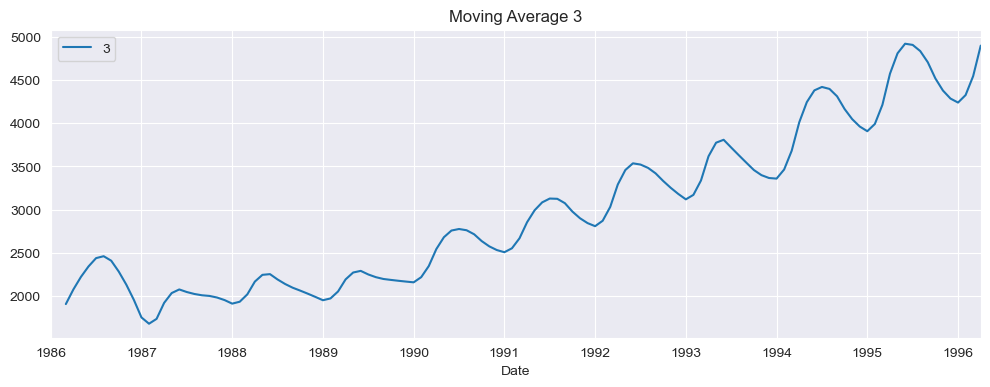

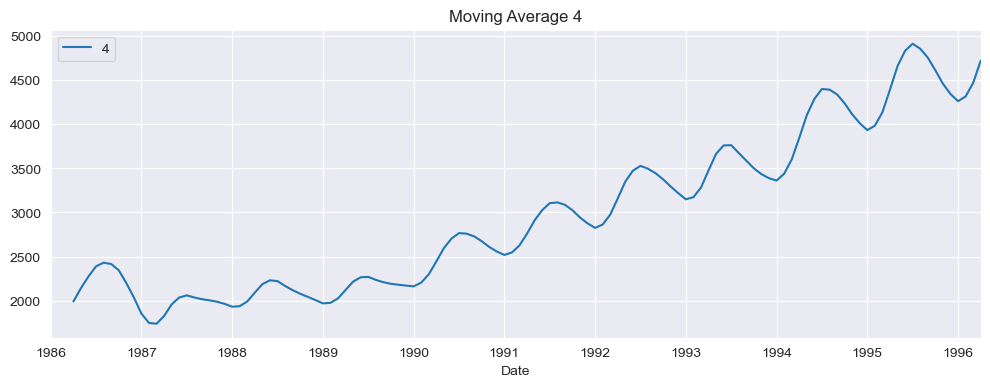

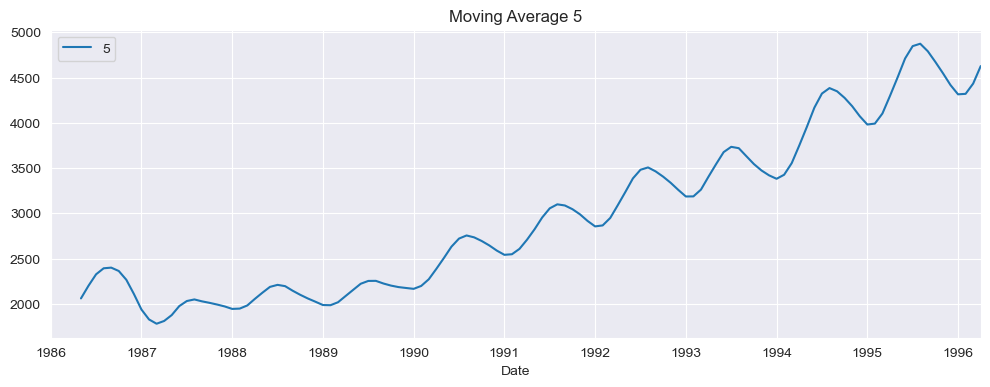

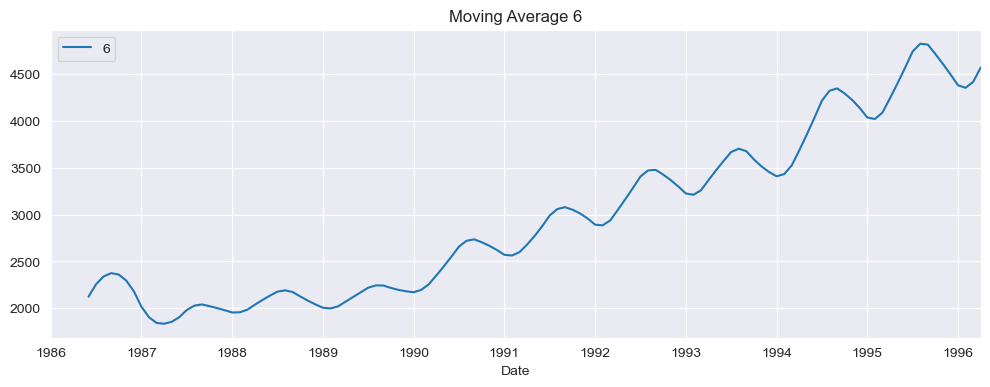

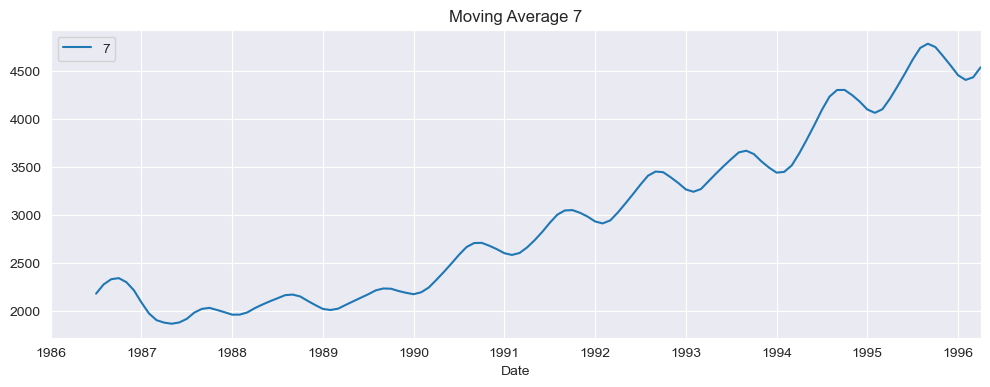

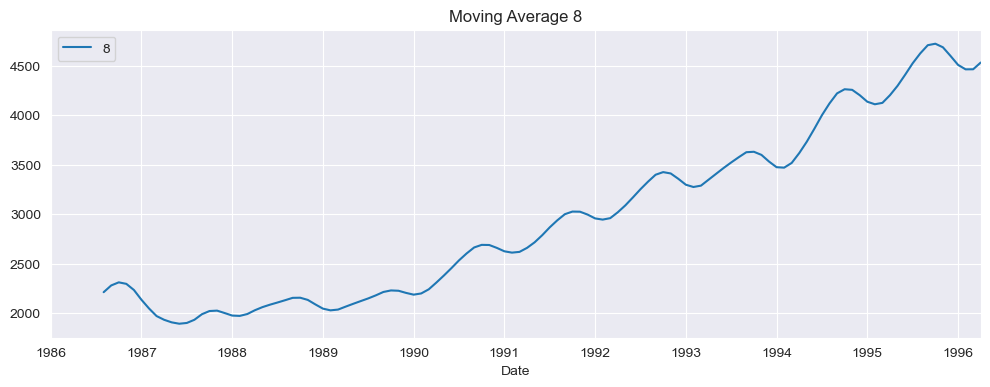

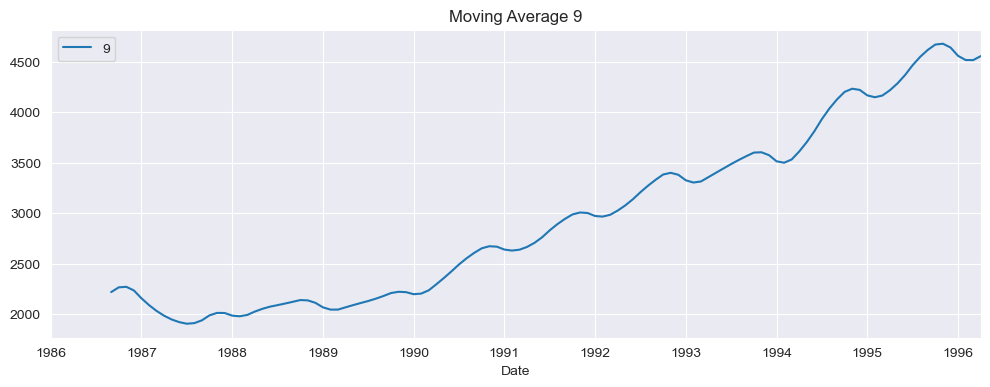

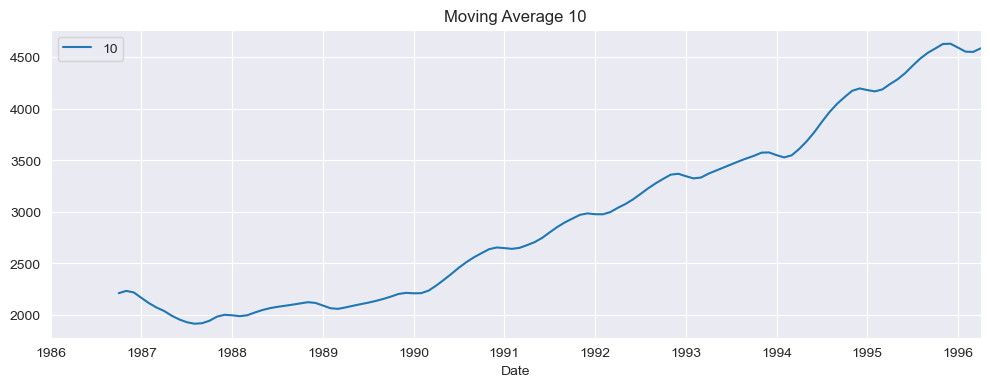

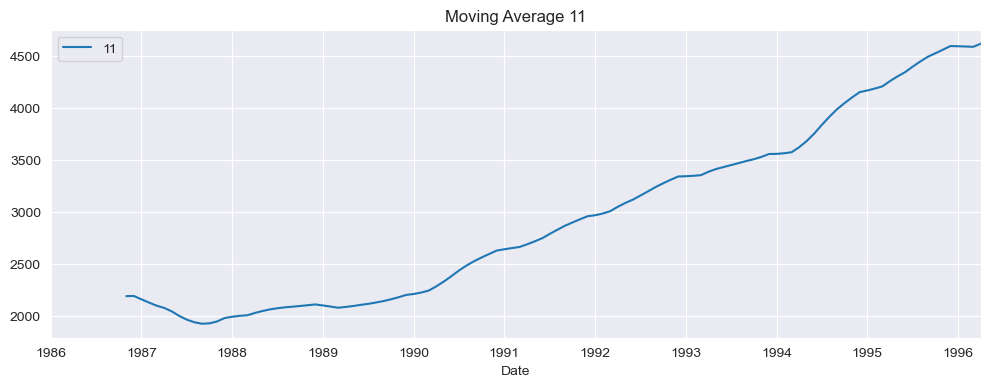

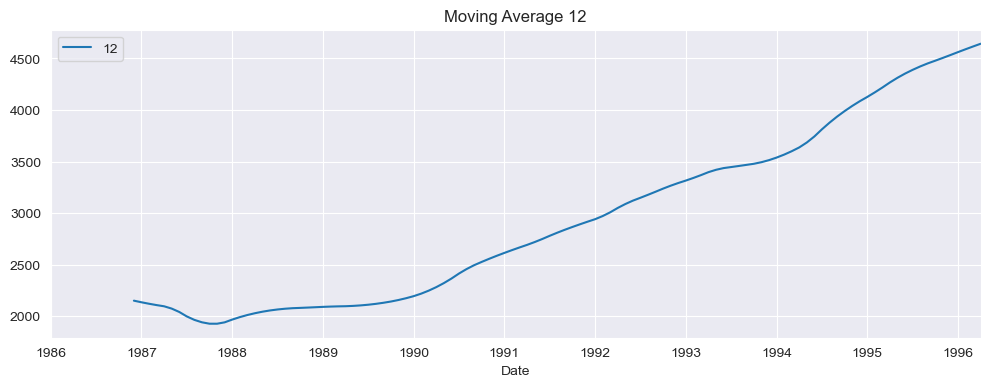

In [44]:
plt.figure(figsize=(12,4))
interpolated_month.Sales.plot(label="org")
plt.title("Original Series")
for i in range(2,13):
    plt.figure(figsize=(12,4))
    interpolated_month["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

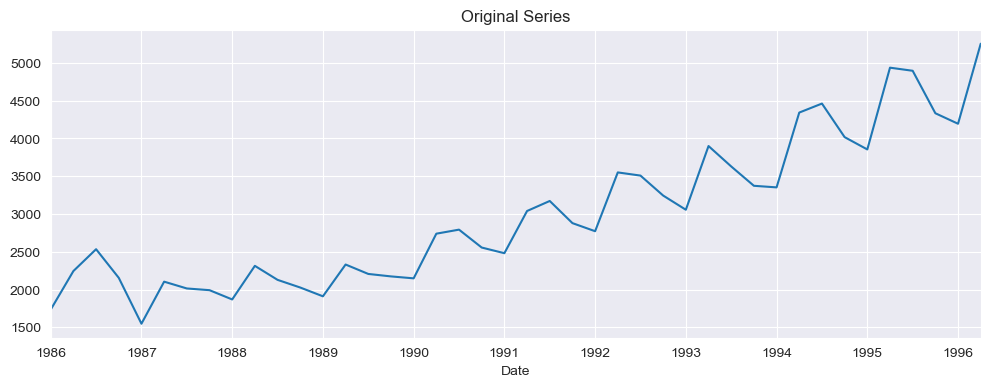

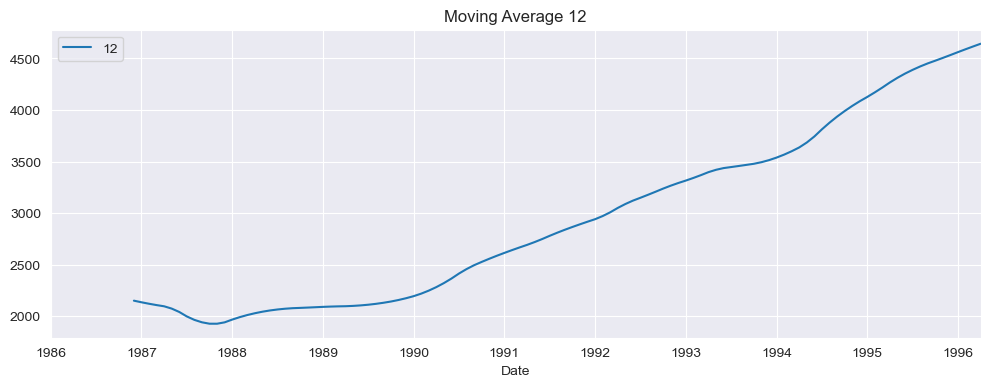

In [45]:
plt.figure(figsize=(12,4))
interpolated_month.Sales.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(12,4))
interpolated_month["Sales"].rolling(12).mean().plot(label=str(12))
plt.title("Moving Average "+str(12))
plt.legend(loc='best')
plt.show()

Additive Seasonal Decomposition

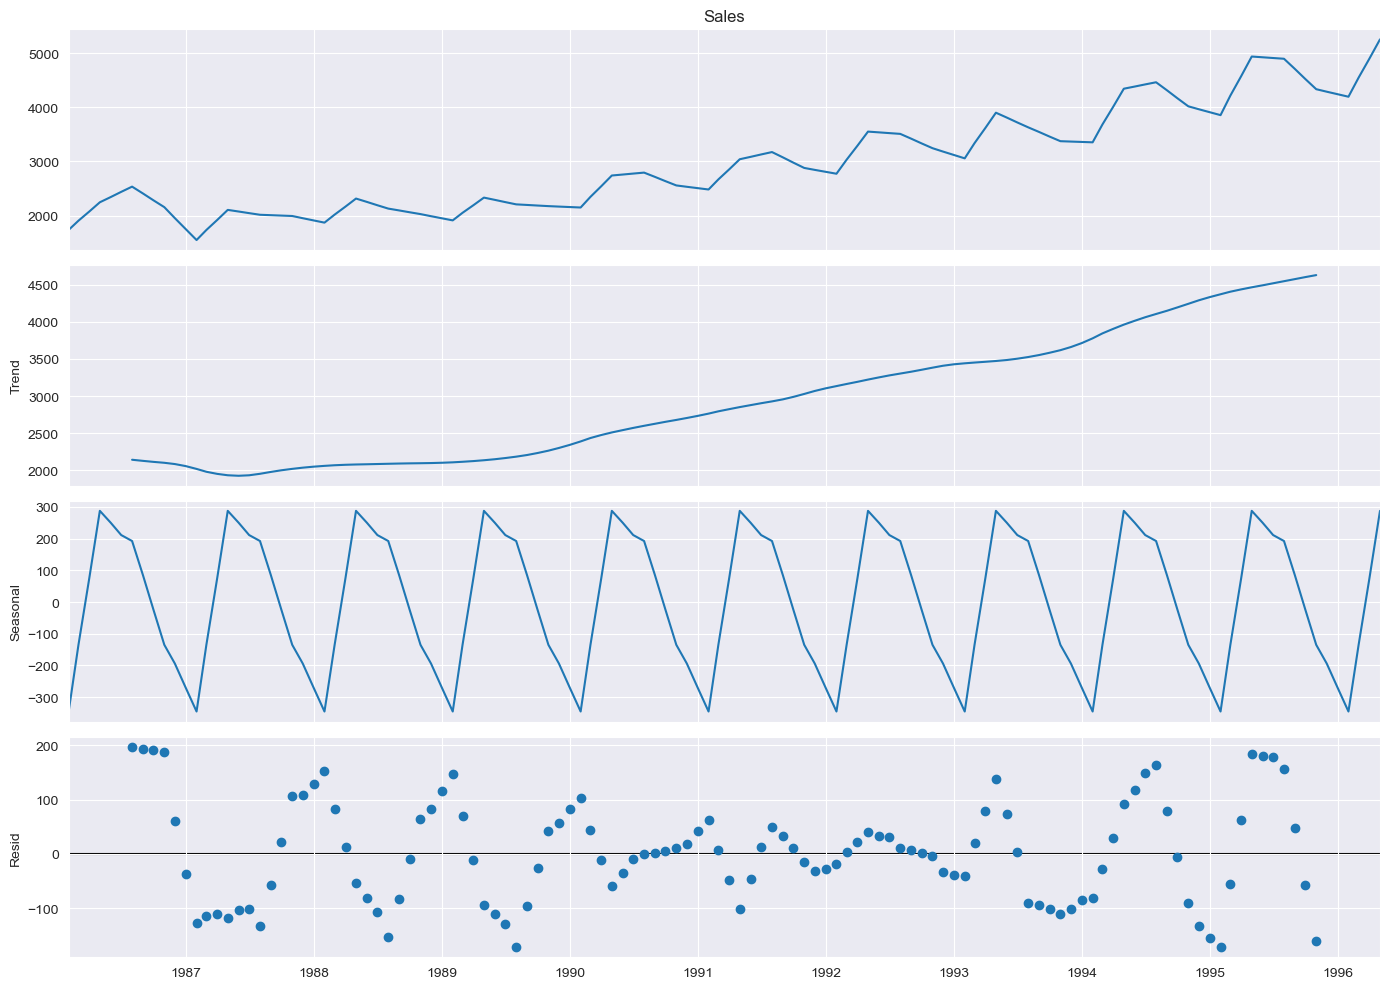

In [46]:
decompose_ts_add = seasonal_decompose(interpolated_month.Sales,period=12, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

Multiplicative Seasonal Decomposition

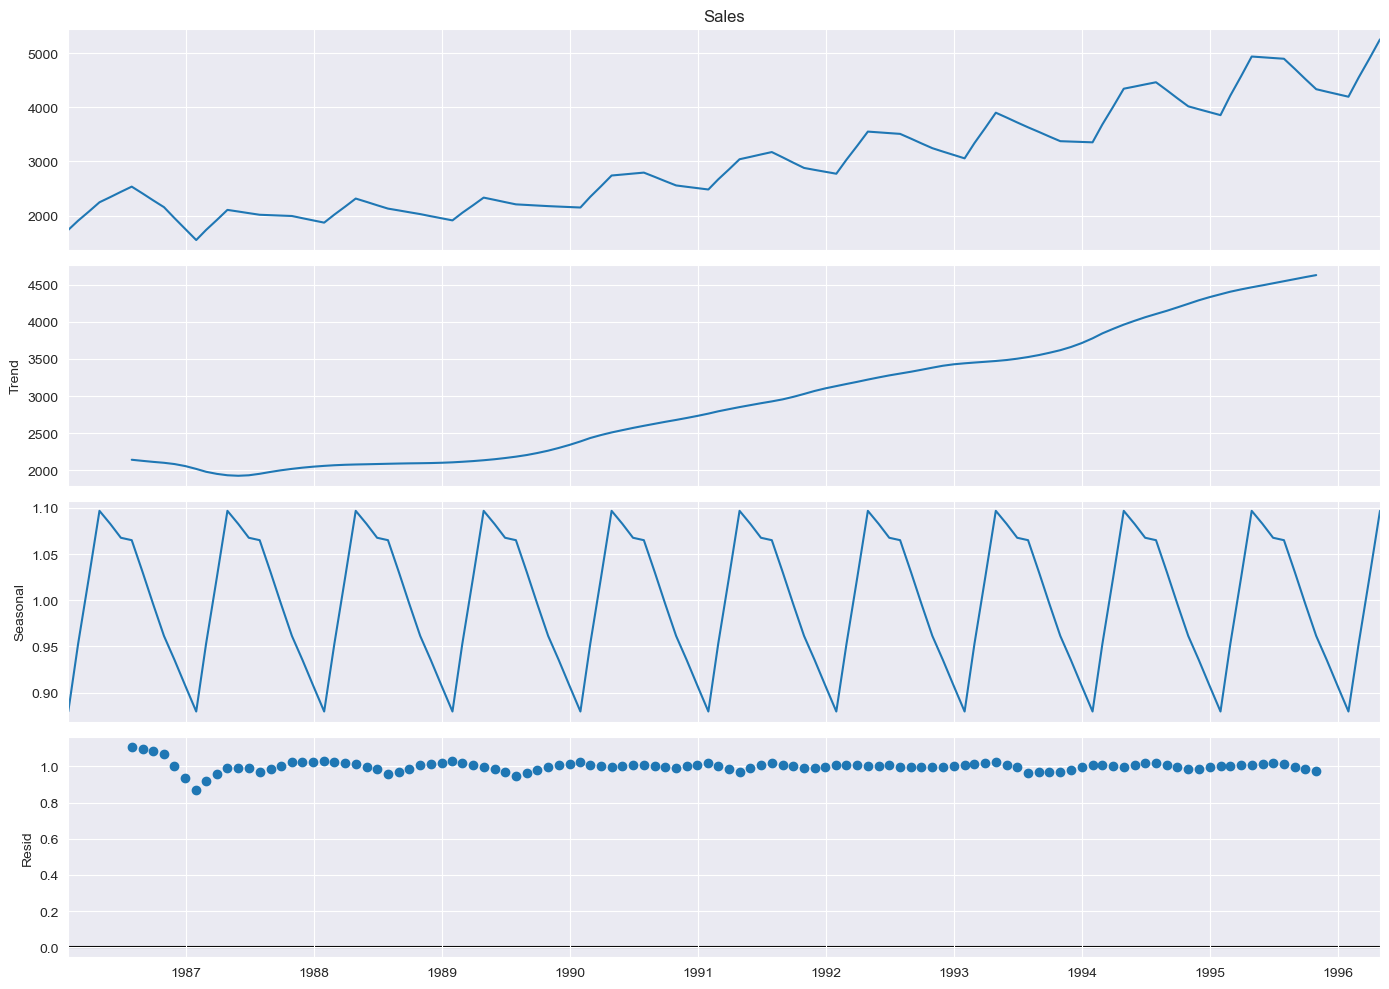

In [47]:
decompose_ts_add = seasonal_decompose(interpolated_month.Sales,period=12, model='multiplicative')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

In [48]:
train_data = interpolated_month[:100]
test_data = interpolated_month[100:]

In [49]:
print('Train:',train_data.index.min(),train_data.index.max(),'\n',
'Test:',test_data.index.min(),test_data.index.max())

Train: 1986-01-31 00:00:00 1994-04-30 00:00:00 
 Test: 1994-05-31 00:00:00 1996-04-30 00:00:00


<Axes: xlabel='Date'>

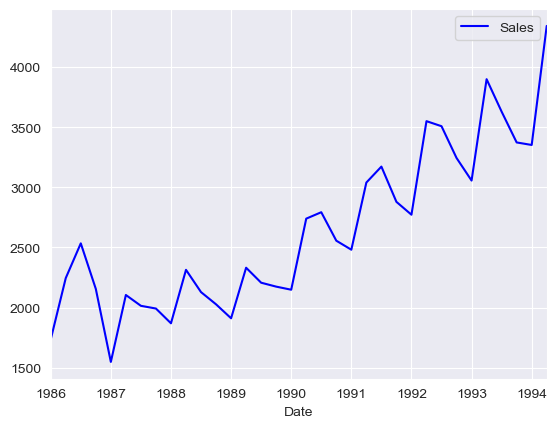

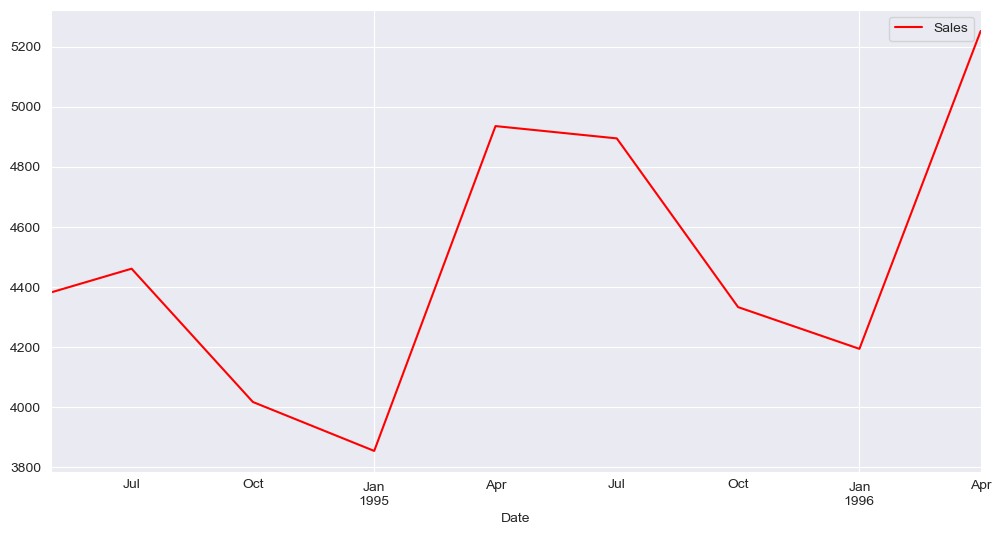

In [50]:
train_data.plot(legend=True,label='TRAIN',color='blue')
test_data.plot(legend=True,label='TEST', figsize=(12,6),color='red')

# Evaluation Metric MAPE

In [51]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

Using Forecast Attribute

In [52]:
ses_model = SimpleExpSmoothing(train_data['Sales']).fit(optimized=True)
test_pred_ses = ses_model.forecast(24)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Sales))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 6.6197194272254025 
 Train Root Mean Squared Error = 129.37951431349904 
 Test Root Mean Squared Error = 381.95422355078995


Using Predict Attribute

In [53]:
ses_model = SimpleExpSmoothing(train_data['Sales']).fit(optimized=True)
test_pred_ses = ses_model.predict(start = test_data.index[0],end = test_data.index[-1])
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Sales))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 6.6197194272254025 
 Train Root Mean Squared Error = 129.37951431349904 
 Test Root Mean Squared Error = 381.95422355078995


Difference between Predict and Forecast attribute ( the same as in "Biscuit" and "Biscoot")

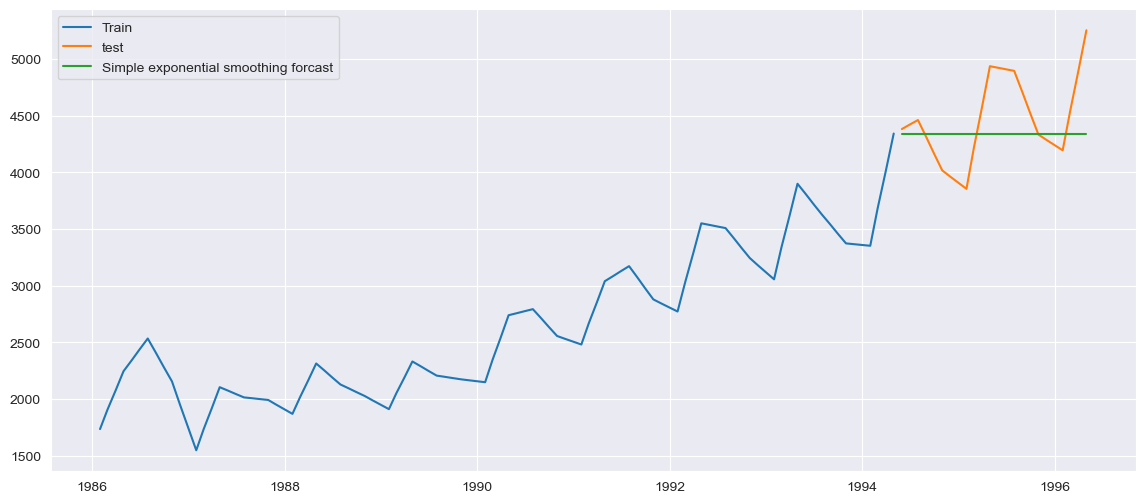

In [54]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

Captures both Level and Trend .

In [55]:
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(24)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_pred_dexp,test_data.Sales))
train_rmse_dexp = sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_dexp))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 89.4931606588976 
 Train Root Mean Squared Error = 108.70855330066725 
 Test Root Mean Squared Error = 4549.83259387513


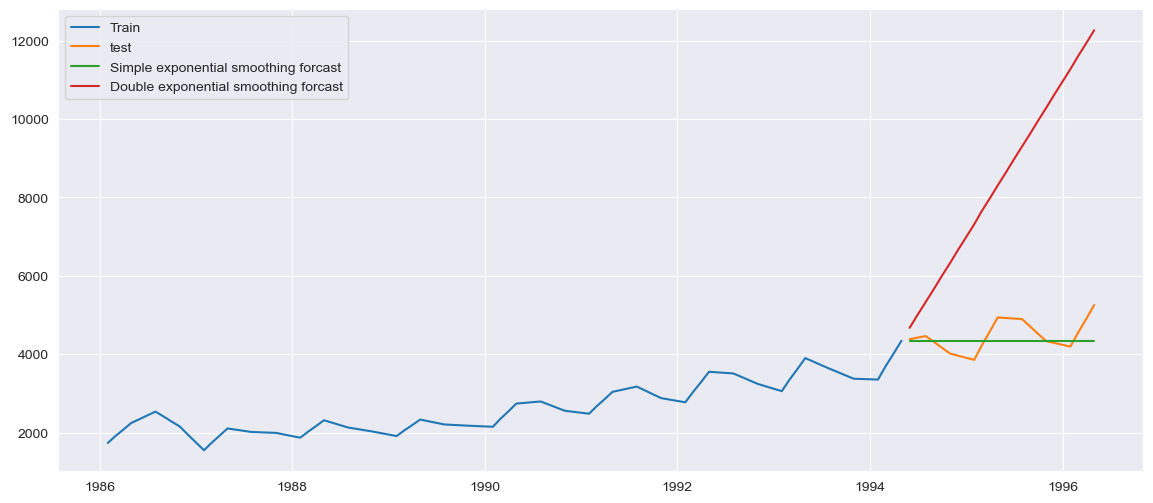

In [56]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

Captures Level, Trend and Seasonality

In [57]:
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(24)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_pred_ad_texp,test_data.Sales))
train_rmse_ad_texp = sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.Sales)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_texp))

Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error = 35.69571274324909 
 Train Root Mean Squared Error = 44.2653652251861 
 Test Root Mean Squared Error = 1828.4767720554398


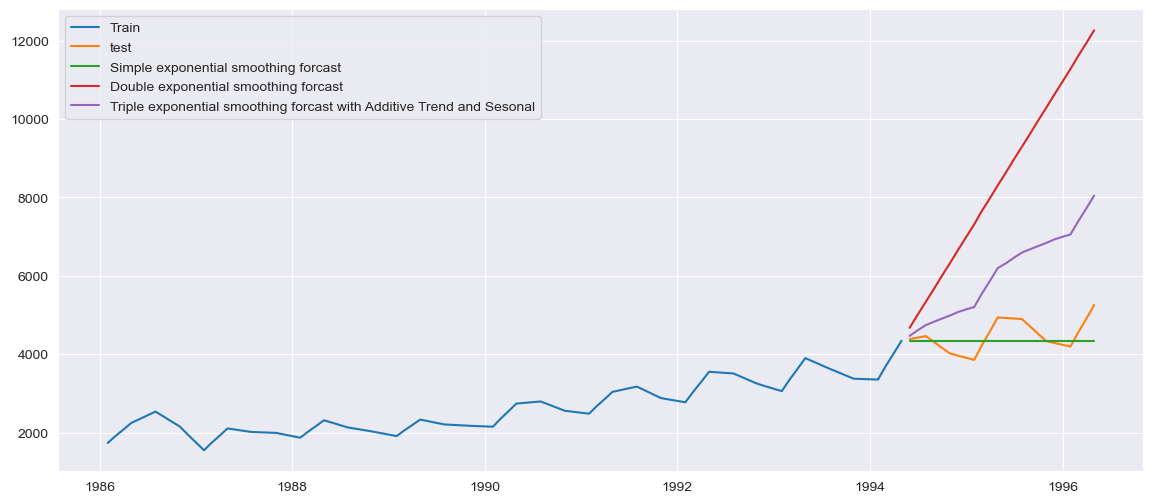

In [58]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential)

In [59]:
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(24)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_pred_mul_ad_texp,test_data.Sales))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_pred_mul_ad_texp,train_data))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_data.Sales)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_ad_texp))

Triple Exponential Method with Multiplicative Seasonality and Additive Trend 
 Mean Absolute Percent Error = 1.487268775553493 
 Train Root Mean Squared Error = 50.223974444654 
 Test Root Mean Squared Error = 78.73325826552858


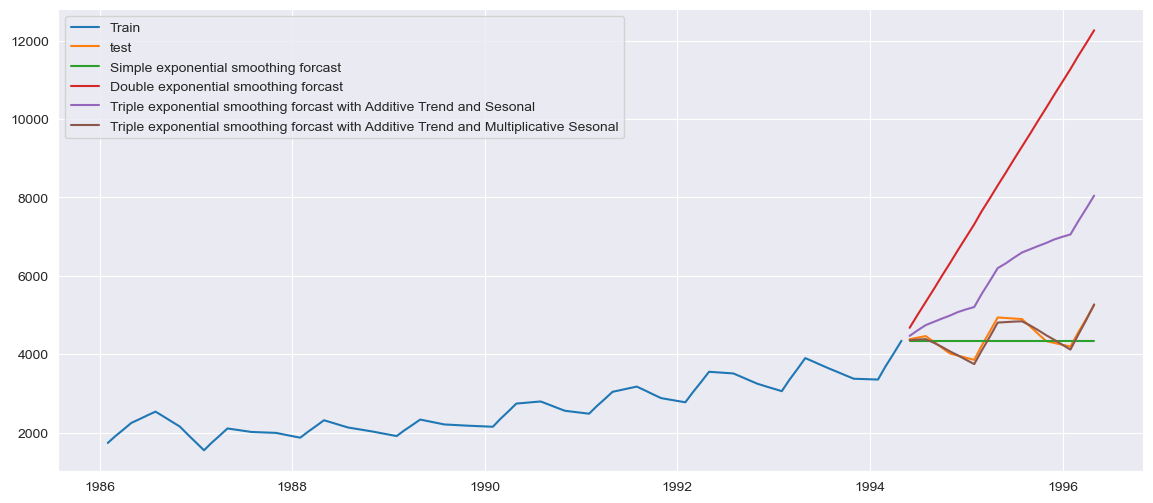

In [60]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.legend(loc='best')
plt.show()

Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)

In [61]:
texp_ad_mul_model  = ExponentialSmoothing(train_data,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(24)
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = sqrt(mean_squared_error(test_pred_ad_mul_texp ,test_data.Sales))
train_rmse_ad_mul_texp  = sqrt(mean_squared_error(train_pred_ad_mul_texp ,train_data))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,test_data.Sales)
print('Triple Exponential Method with Additive Seasonality and Multiplicative Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_mul_texp ))

Triple Exponential Method with Additive Seasonality and Multiplicative Trend 
 Mean Absolute Percent Error = 5.168784154878948 
 Train Root Mean Squared Error = 165.78104360617877 
 Test Root Mean Squared Error = 270.08479145849486


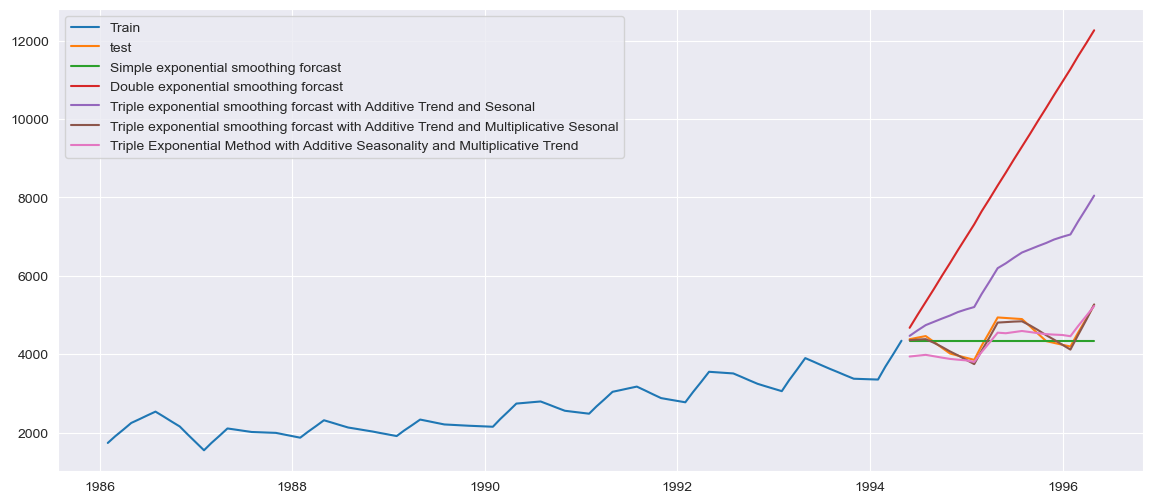

In [62]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.legend(loc='best')
plt.show()

Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)

In [63]:
texp_mul_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(24)
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = sqrt(mean_squared_error(test_pred_mul_texp ,test_data.Sales))
train_rmse_mul_texp  = sqrt(mean_squared_error(train_pred_mul_texp ,train_data))
mape_mul_texp  = MAPE(test_pred_mul_texp,test_data.Sales)
print('Triple Exponential Method with multiplicative Trend and Seasonality',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_texp ))

Triple Exponential Method with multiplicative Trend and Seasonality 
 Mean Absolute Percent Error = 1.8078233252851945 
 Train Root Mean Squared Error = 49.43910507382248 
 Test Root Mean Squared Error = 101.65134880354202


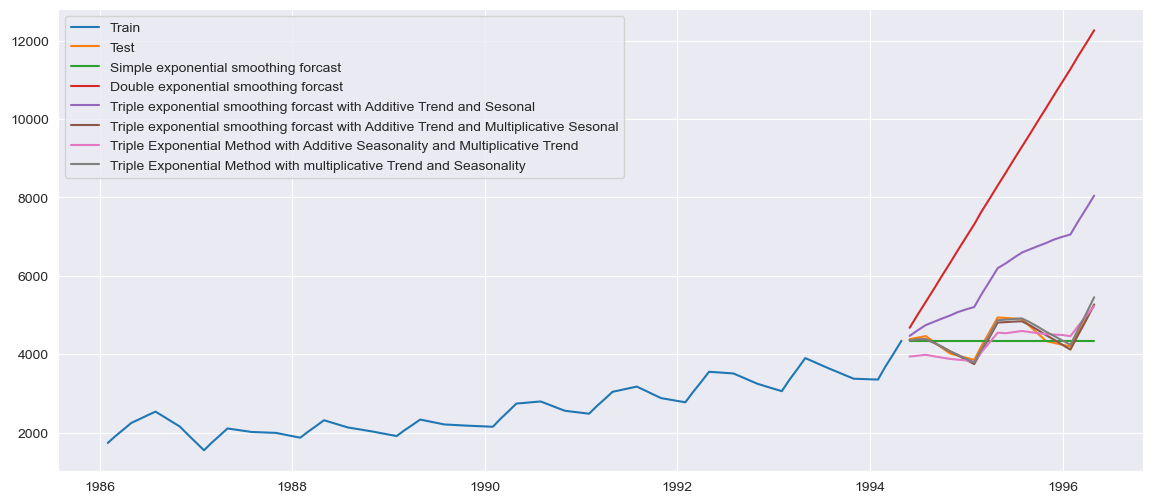

In [64]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

In [65]:
#Comparing the results 

Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_ad","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_mul"]),\
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),\
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),\
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

Models  Train_RMSE  Test_MAPE(%)  Test_RMSE_Values
0  Triple_Exp_mul_ad   50.223974      1.487269         78.733258
1     Triple_Exp_mul   49.439105      1.807823        101.651349
2  Triple_Exp_ad_mul  165.781044      5.168784        270.084791
3         Simple_Exp  129.379514      6.619719        381.954224
4      Triple_Exp_ad   44.265365     35.695713       1828.476772
5         Double_Exp  108.708553     89.493161       4549.832594

Visualizing Models Performance

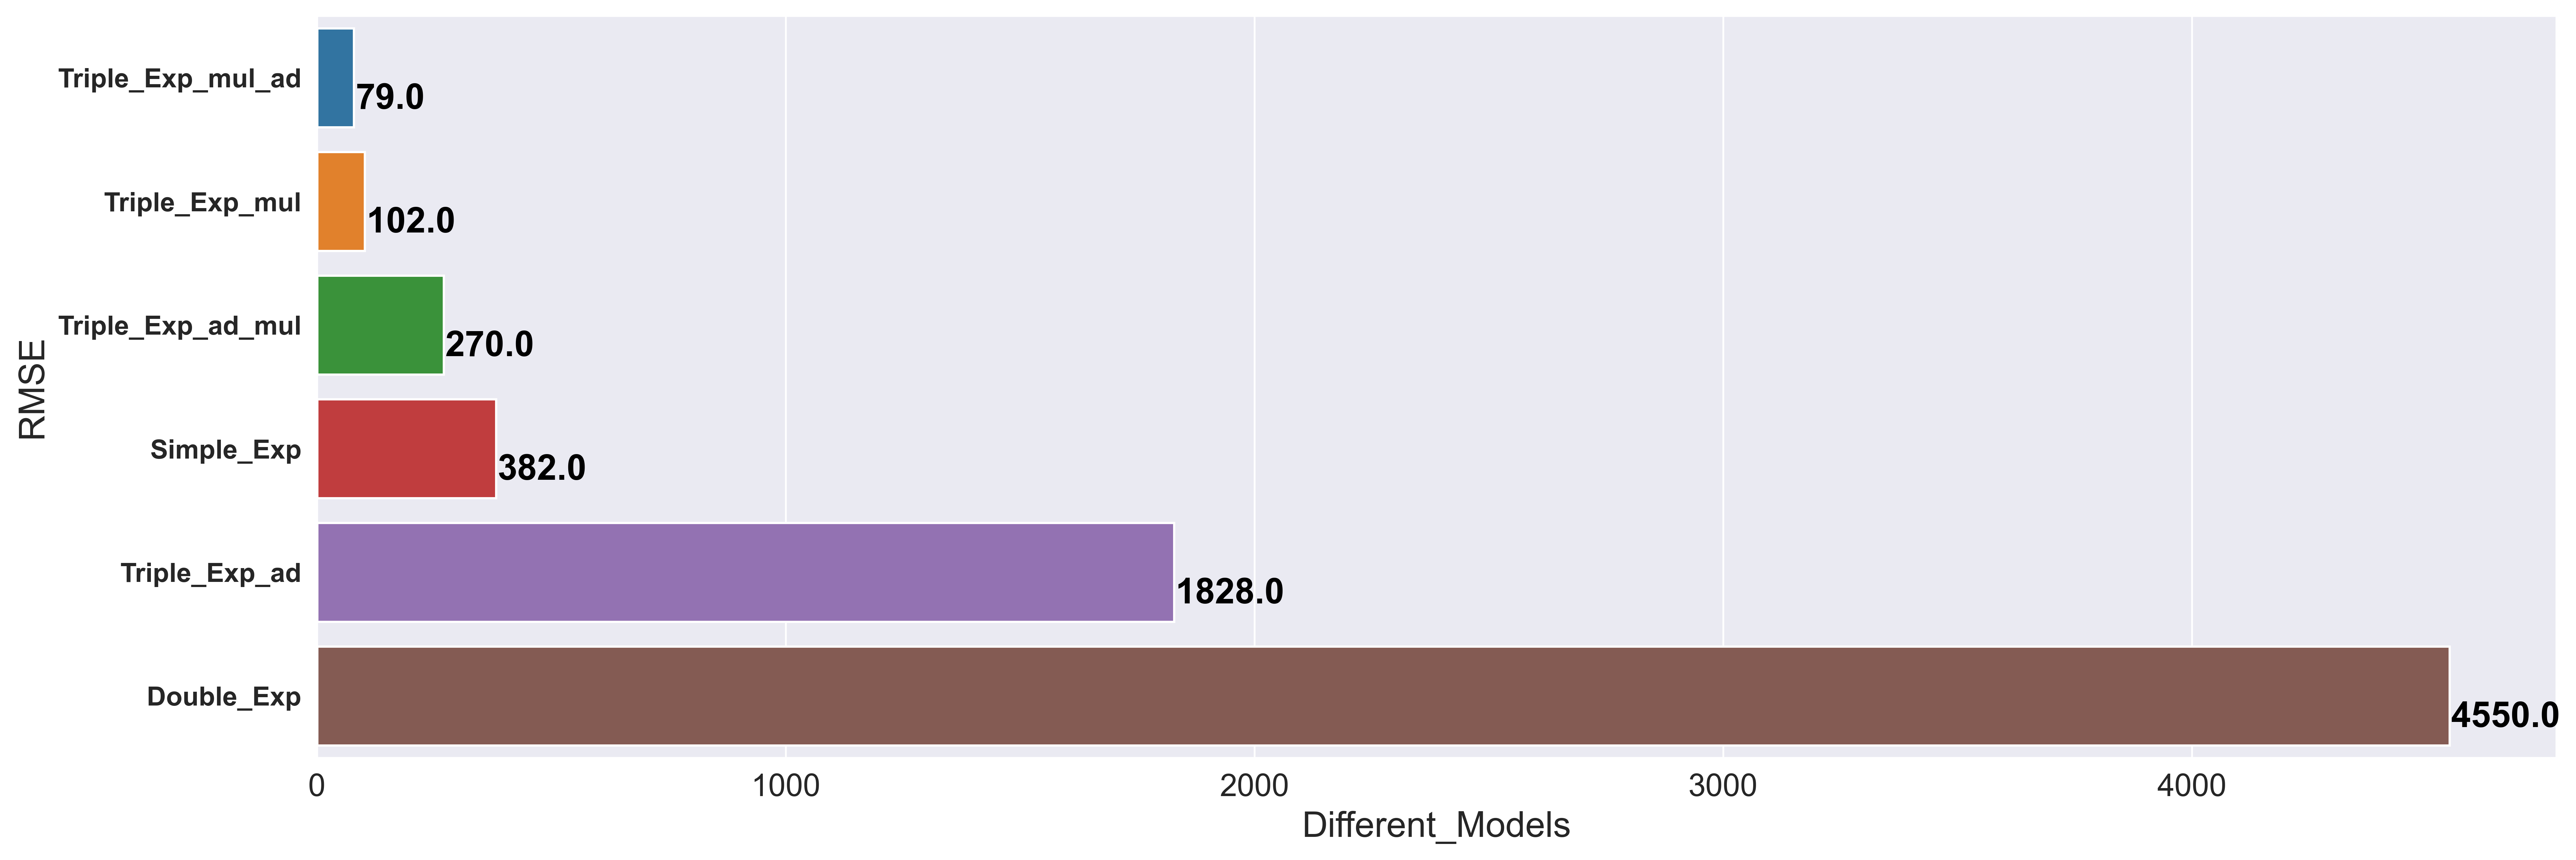

In [66]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='Test_RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

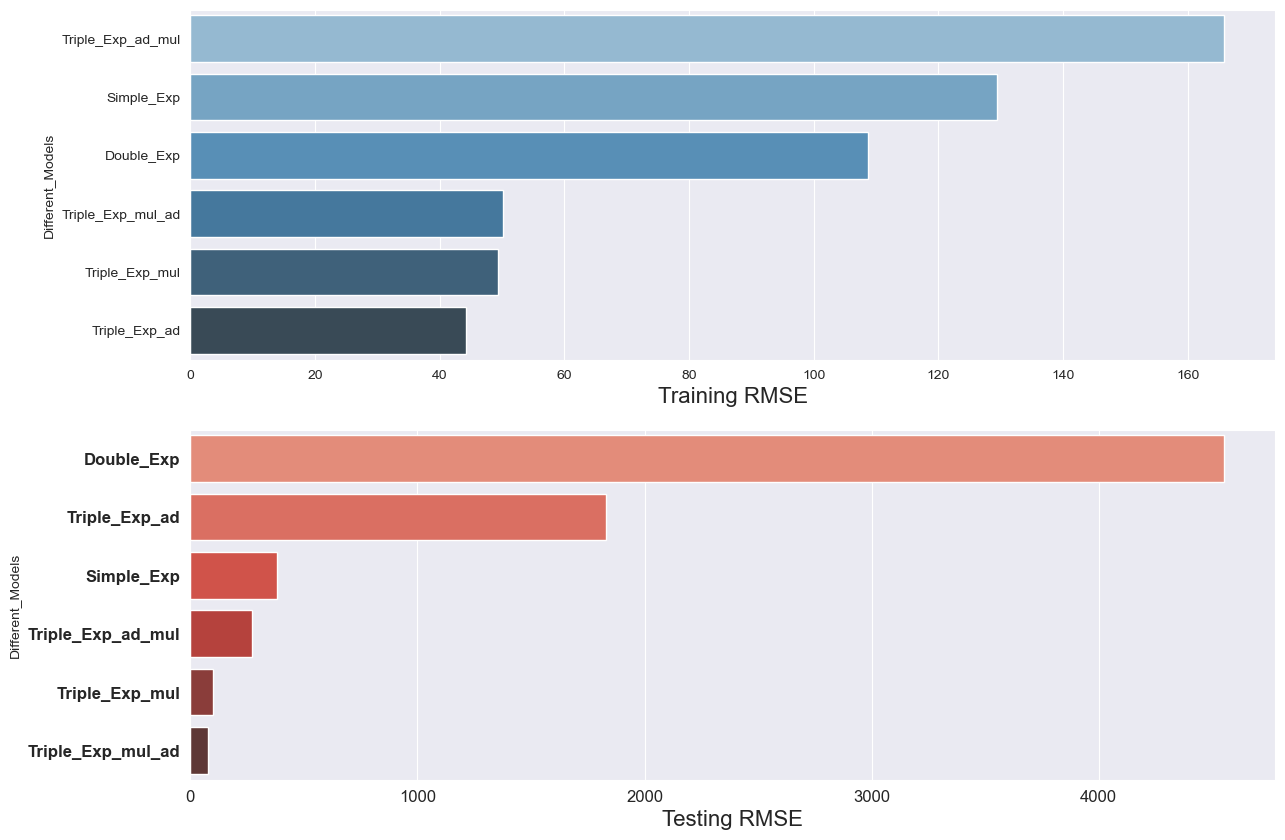

In [67]:
f, axes = plt.subplots(2,1, figsize=(14,10))
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=12)
train_rmse = table_evaluation.sort_values(by=['Train_RMSE'], ascending=False)

sns.barplot(x='Train_RMSE', y='Models', data = train_rmse, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('Training RMSE', size=16)
axes[0].set_ylabel('Different_Models')

test_rmse = table_evaluation.sort_values(by=['Test_RMSE_Values'], ascending=False)

sns.barplot(x='Test_RMSE_Values', y='Models', data = test_rmse, palette='Reds_d', ax = axes[1])
axes[1].set_xlabel('Testing RMSE', size=16)
axes[1].set_ylabel('Different_Models')

plt.show()

As we have quarterly data the window size for moving average is equal to 4

In [68]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=4).mean()
    movingSTD = timeseries.rolling(window=4).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

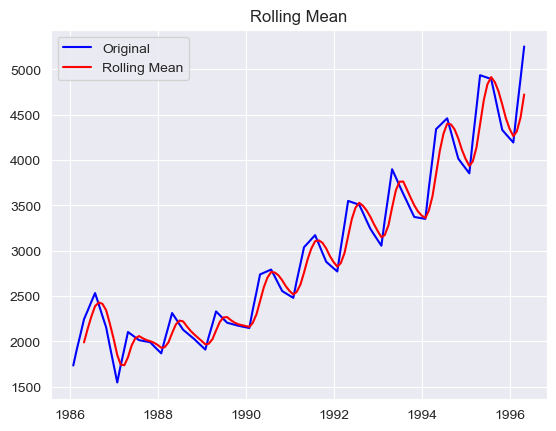

Results of Dickey Fuller Test:
Test Statistic                   0.572599
p-value                          0.986920
#Lags Used                      10.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


In [69]:
sales= pd.DataFrame()
sales['Sales'] = interpolated_month[['Sales']]
test_stationarity(sales)

In [70]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [71]:
adf_test(sales.Sales)

Fail to reject the null hypothesis
Data is non-stationary


Square Root Transform

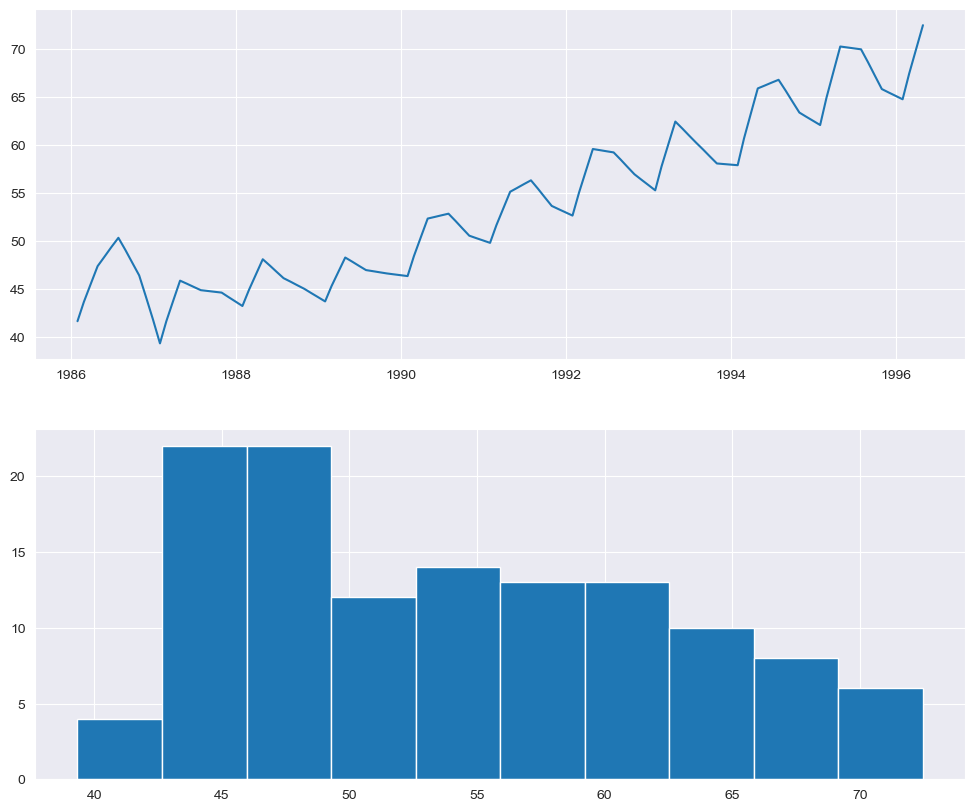

In [72]:
square_root= pd.DataFrame()
square_root = interpolated_month[['Sales']]
square_root['Sales'] = np.sqrt(square_root.Sales)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['Sales'])
#Histogram
plt.subplot(212)
plt.hist(square_root['Sales'])
plt.show()

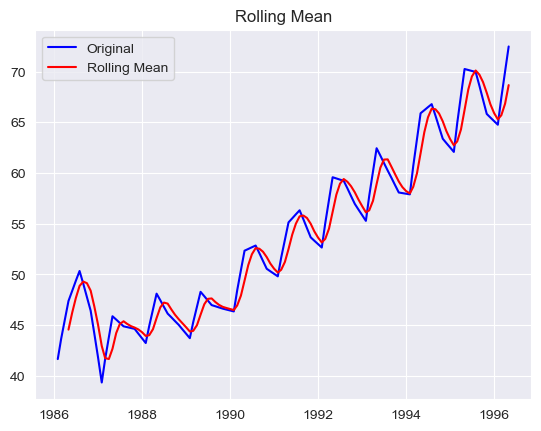

Results of Dickey Fuller Test:
Test Statistic                   0.728012
p-value                          0.990381
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [73]:
test_stationarity(square_root)

In [74]:
adf_test(square_root.Sales)

Fail to reject the null hypothesis
Data is non-stationary


Log Transform

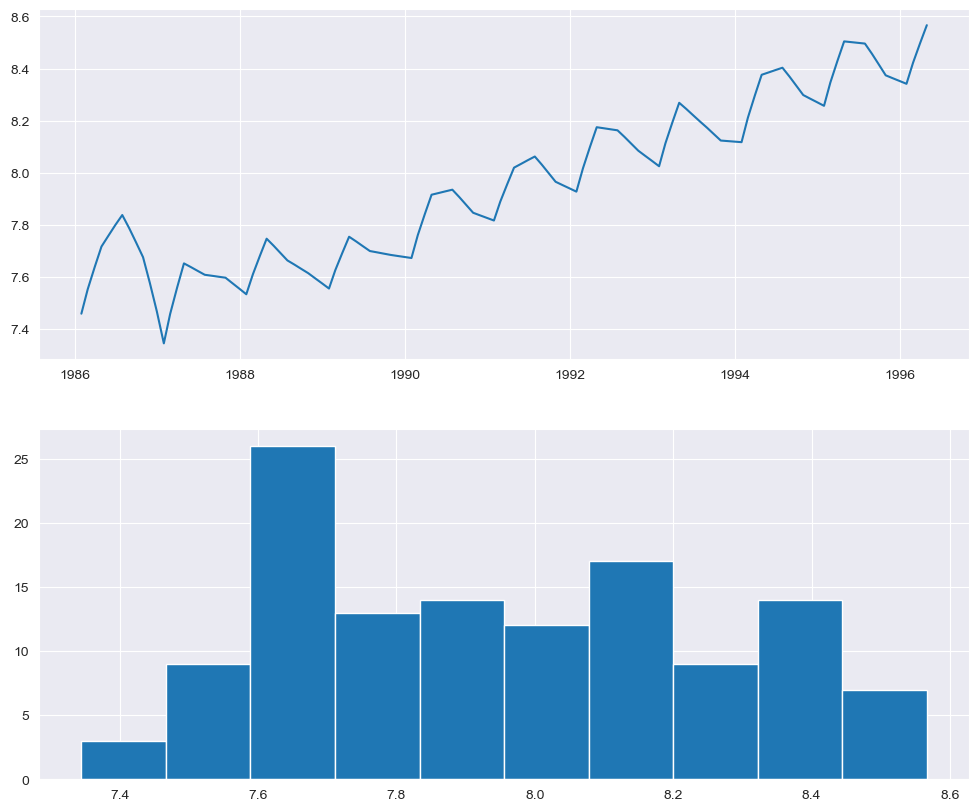

In [76]:
log = pd.DataFrame()
log = interpolated_month[['Sales']]
log['Sales'] = np.log(log.Sales)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Sales'])
#Histogram
plt.subplot(212)
plt.hist(log['Sales'])
plt.show()

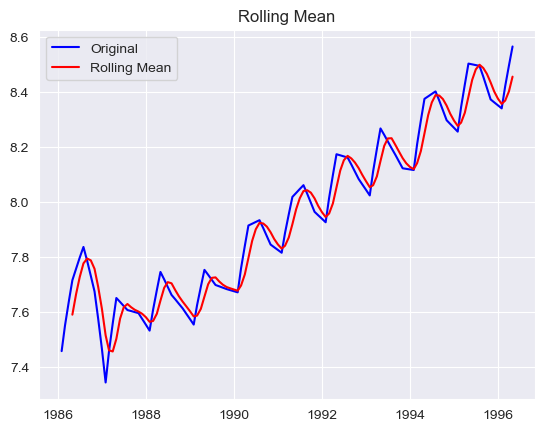

Results of Dickey Fuller Test:
Test Statistic                   0.451508
p-value                          0.983322
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [77]:
test_stationarity(log)

In [78]:
adf_test(log.Sales)

Fail to reject the null hypothesis
Data is non-stationary


Sales
Date                
1986-01-31  7.458663
1986-02-28  7.552170
1986-03-31  7.637676
1986-04-30  7.716443
1986-05-31  7.758437

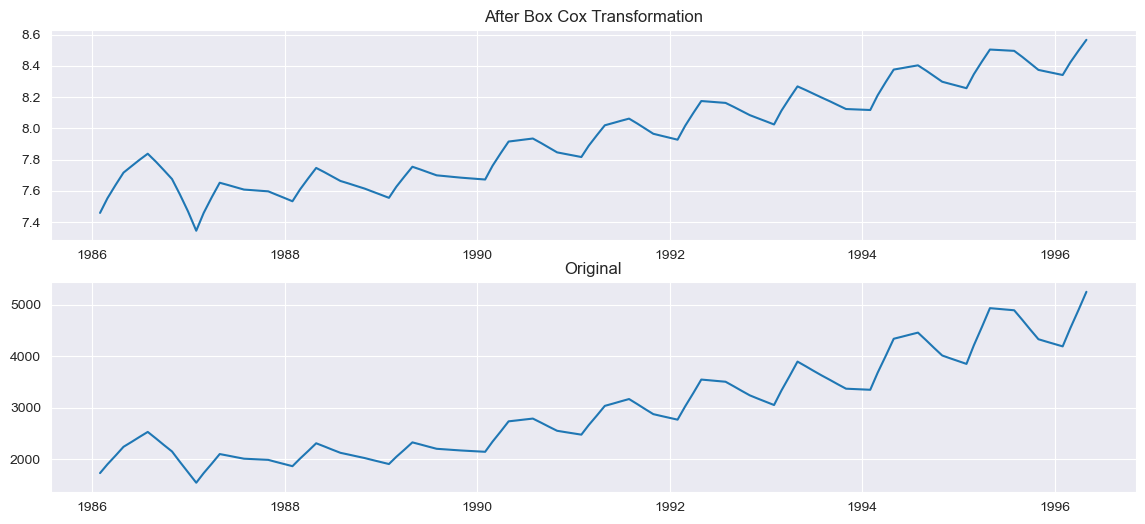

In [79]:
data_boxcox = pd.DataFrame()
data_boxcox['Sales'] = pd.Series(boxcox(interpolated_month['Sales'], lmbda=0), interpolated_month.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(14,6),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(interpolated_month, label='original')
axis[1].set_title('Original')
plt.show()

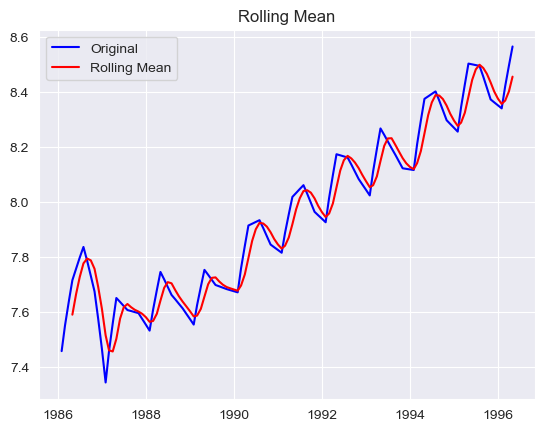

Results of Dickey Fuller Test:
Test Statistic                   0.451508
p-value                          0.983322
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [80]:
test_stationarity(data_boxcox)

In [81]:
adf_test(data_boxcox)

Fail to reject the null hypothesis
Data is non-stationary


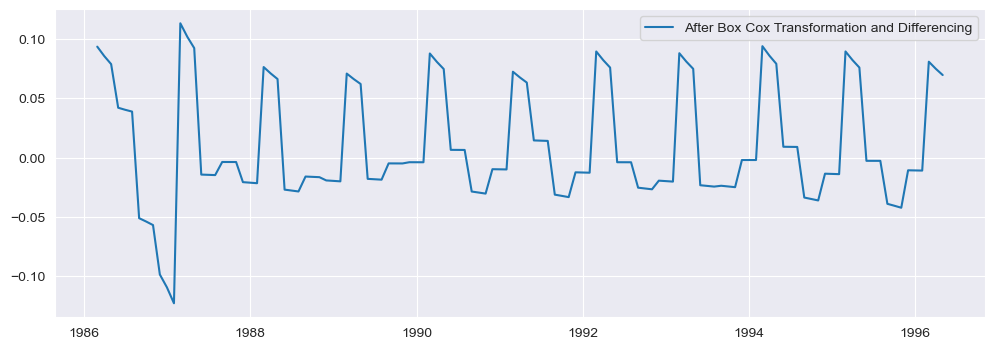

In [82]:
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

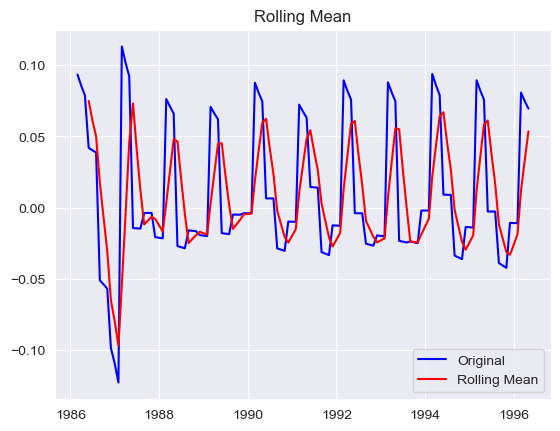

Results of Dickey Fuller Test:
Test Statistic                  -3.030060
p-value                          0.032181
#Lags Used                      12.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [83]:
#check this log transfered data with function
test_stationarity(data_boxcox_diff)

In [84]:
adf_test(data_boxcox_diff.Sales)

Reject the null hypothesis
Data is stationary


In [85]:
# grid search ARIMA parameters for a time series

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [86]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    #print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [87]:
train_data_boxcox = data_boxcox[:100]
test_data_boxcox = data_boxcox[100:]
train_data_boxcox_diff = data_boxcox_diff[:99]
test_data_boxcox_diff = data_boxcox_diff[99:]

In [88]:
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
evaluate_models(train_data_boxcox_diff, p_values, d_values, q_values)

ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isnan' not supported for the input types, and the inputs could not be

In [89]:
model = ARIMA(train_data_boxcox_diff, order=(3, 0, 2))
model_fit = model.fit()
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
# We did differencing. So we need to revert it by adding the consecutive observations.
# For that we are using cumsum() method
y_hat_ar['ar_forecast'] = y_hat_ar['ar_forecast'].cumsum()
# We removed the first observations after differencing as it was null. Hence, adding the first observation back.
y_hat_ar['ar_forecast'] = y_hat_ar['ar_forecast'].add(data_boxcox.Sales[0])
# Now doing the reverse transformation 
# We have done Box Cox Log Log transformation with lambda = 0
# Hence, we have to the exponential as it is the reverse of the log.
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast'])

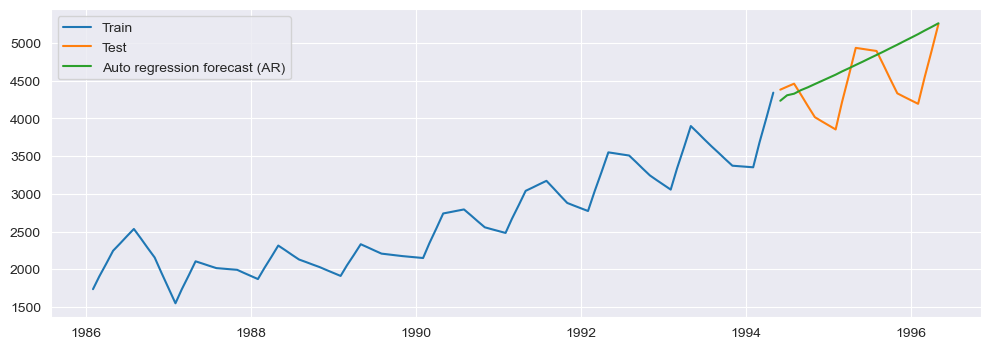

In [90]:
plt.figure(figsize=(12,4))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['ar_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

RMSE (Root Mean Squared Error)

In [91]:
rmse_ARIMA = np.sqrt(mean_squared_error(test_data, y_hat_ar['ar_forecast'][test_data.index.min():])).round(2)
rmse_ARIMA

455.62

MAPE (Mean Absolute Percent Error)

In [93]:
mape_arima = round(np.mean(np.abs((test_data - y_hat_ar['ar_forecast'][test_data.index.min():])/test_data)*100),2)
mape_arima

nan

The mean of the Residual should be zero or close to Zero

In [94]:
model_residual = model_fit.resid
model_residual.mean()

0.00022546452265170152

Residuals must be stationary

In [95]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


No autocorrelation between residuals

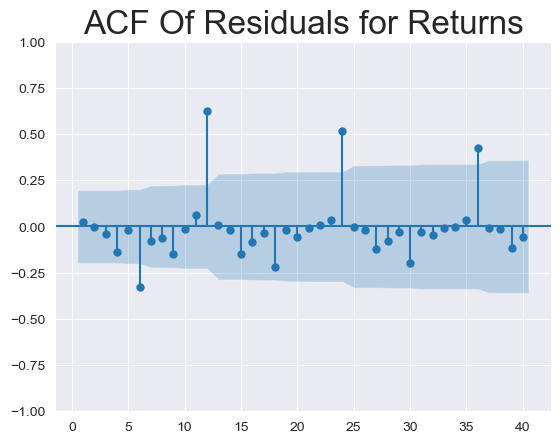

In [96]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

Residuals must be random

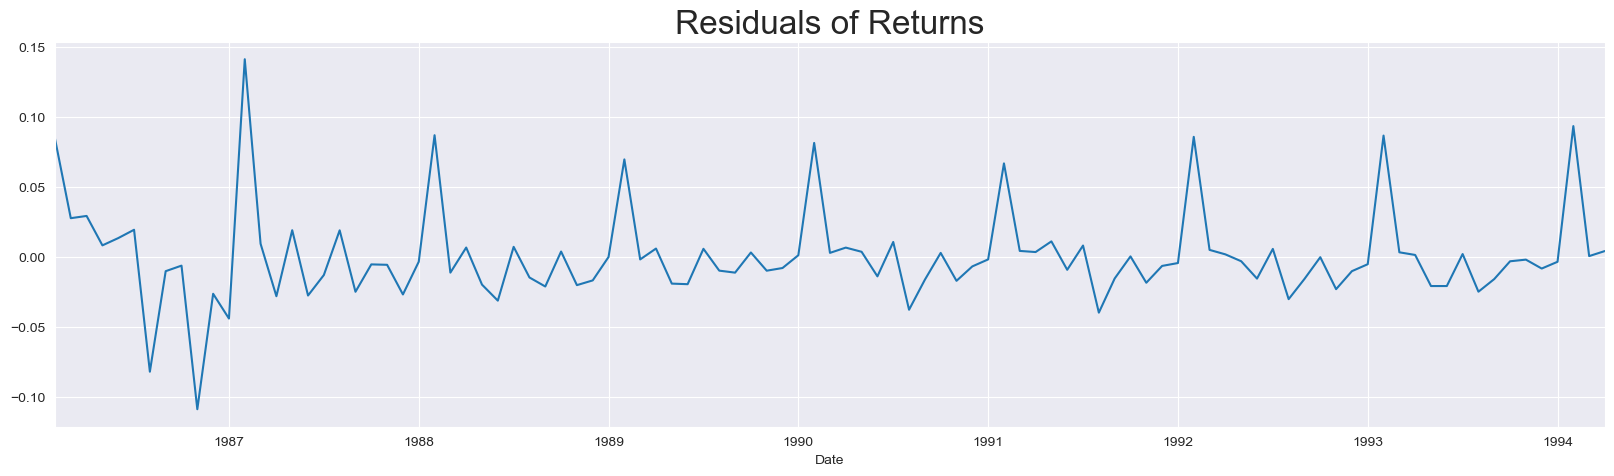

In [97]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

ARIMA on the Original Data without UpSampling

In [98]:
# separate out a validation dataset
size = int(np.round(len(df1)*0.70,))

cocacola_train = df1.Sales[:size]
cocacola_validation = df1.Sales[size:]
print('Dataset %d, Validation %d' % (len(cocacola_train), len(cocacola_validation)))
cocacola_train.to_csv('cocacola_train.csv', header=False)
cocacola_validation.to_csv('cocacola_validation.csv', header=False)

Dataset 29, Validation 13


In [99]:
# separate out a validation dataset

print('Dataset %d, Validation %d' % (len(train_data), len(test_data)))
train_data.to_csv('cocacola_train.csv', header=False)
test_data.to_csv('cocacola_validation.csv', header=False)

Dataset 100, Validation 24


In [103]:
# separate out a validation dataset
size = int(np.round(len(cocacola_train)*0.70,))

train_data = cocacola_train[:size]
test_data = cocacola_train[size:]
print('Dataset %d, Validation %d' % (len(train_data), len(test_data)))

Dataset 20, Validation 9


In [104]:
print('Dataset %d, Validation %d' % (len(train_data), len(test_data)))

Dataset 20, Validation 9


In [105]:
model = ARIMA(train_data,order=(4, 1, 4))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   20
Model:                 ARIMA(4, 1, 4)   Log Likelihood         -6767268815.990
Date:                Wed, 01 Nov 2023   AIC                    13534537649.981
Time:                        19:41:41   BIC                    13534537658.481
Sample:                    01-01-1986   HQIC                   13534537651.419
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1        2.29e-07   3.67e-10    623.805      0.000    2.28e-07     2.3e-07
ar.L2      -3.244e-07   3.05e-10  -1061.953      0.000   -3.25e-07   -3.24e-07
ar.L3       -8.11e-08   4.02e-10   -201.843      0.000   -8.19e-08   -8.03e-08
ar.L4       1.738e-07   3.09e-10    563.312      0.000    1.73e-07    1.74e-07
ma.L1        2.29e-07   3.67e-10    623.785      0.000    2.28e-07     2.3e-07
ma.L2      -3.244e-07   3.05e-10  -1061.975      0.000   -3.25e-07   -3.24e-07
ma.L3       -8.11e-08   4.02e-10   -201.847      0.000   -8.19e-08   -8.03e-08
ma.L4       1.738e-07   3.09e-10    563.303      0.000    1.73e-07    1.74e-07
sigma2         0.0002    1.4e-13   1.08e+09      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.43   Prob(JB):                         0.75
Heteroskedasticity (H):               0.36   Skew:                             0.20
Prob(H) (two-sided):                  0.24   Kurtosis:                         2.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.22e+17. Standard errors may be unstable.
"""

Use model to predict

In [106]:
# Obtain predicted values
start=len(train_data)
end=len(cocacola_train)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels')
predictions = predictions.rename('ARIMA(4,1,4) Predictions')

In [107]:
# Compare predictions to expected values
for i in range(len(test_data)):
    print(f"predicted={predictions[i]:<.10}, expected={test_data[i]}")

predicted=2556.009747, expected=2480.9739990234375
predicted=2556.010097, expected=3039.522994995117
predicted=2556.010154, expected=3172.115997314453
predicted=2556.010072, expected=2879.0009994506836
predicted=2556.010072, expected=2772.0
predicted=2556.010072, expected=3550.0
predicted=2556.010072, expected=3508.0
predicted=2556.010072, expected=3243.859992980957
predicted=2556.010072, expected=3056.0


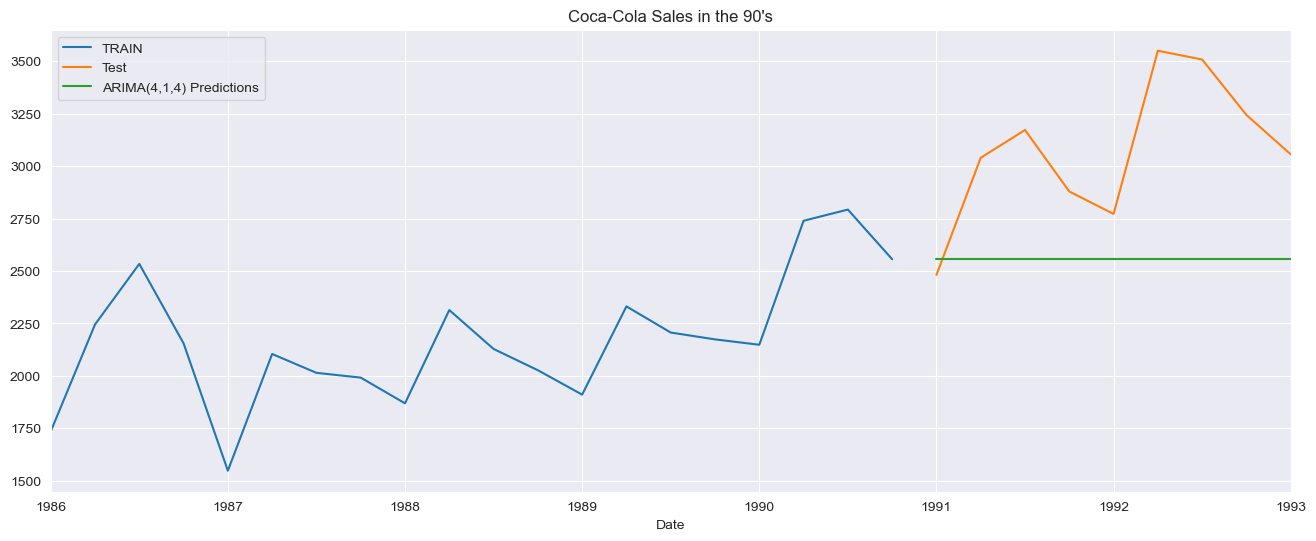

In [108]:
# Plot predictions against known values
title = "Coca-Cola Sales in the 90's"
ylabel='Sales'
xlabel='' 

train_data.plot(legend=True,label='TRAIN' ,figsize=(16,6),title=title)
test_data.plot(legend=True,label='Test',figsize=(16,6),title=title)
predictions.plot(legend=True)
plt.show()

Evaluate the Model

In [109]:
from statsmodels.tools.eval_measures import rmse
rmse_arima = rmse(test_data, predictions)
rmse_arima.round(2)

613.5

In [110]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# We are only passing the Box Cox because the ARIMAX will perform the differencing internally
# seasonal_order P=1, Q=1, D=1 and m=12
# m=12 . Because the seasonality is monthly.

In [111]:
model = SARIMAX(train_data_boxcox, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit= model.fit()
y_hat_sarima = data_boxcox_diff.copy()

In [112]:
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

MAPE (Mean Absolute Percent Error)

In [113]:
mape_sarima = round(np.mean(np.abs((test_data - y_hat_sarima['sarima_forecast'][test_data.index.min():])/test_data)*100),2)
mape_sarima

nan

The mean of the Residual should be zero or close to Zero

In [114]:
model_residual = model_fit.resid
model_residual.mean()

0.037051437702636296

Residuals must be stationary

In [115]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


No autocorrelation between residuals

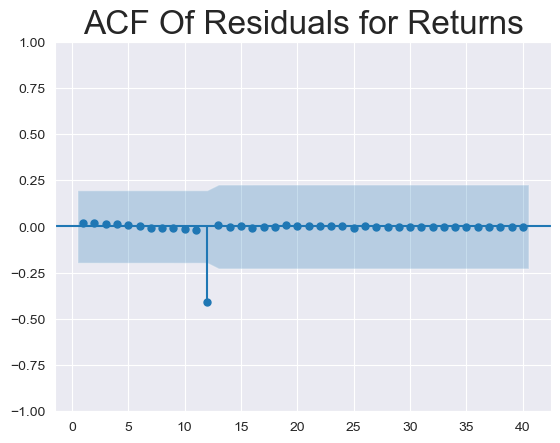

In [116]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

Residuals must be random

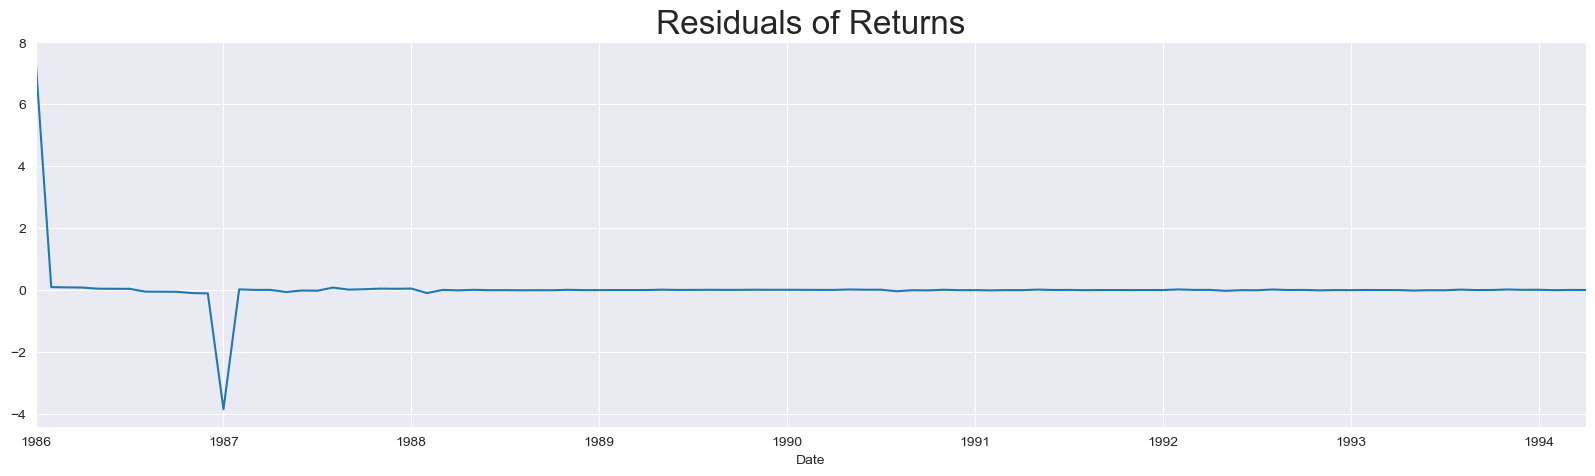

In [117]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

Creating Dummy Variables of the Categorical Feature Month of Date Time feature

In [118]:
interpolated_month.reset_index(inplace=True)
interpolated_month['t'] = np.arange(1,len(interpolated_month)+1)
interpolated_month['t_squared'] = np.square(interpolated_month.t)
interpolated_month["month"] = interpolated_month.Date.dt.strftime("%b") # month extraction
interpolated_month["year"] = interpolated_month.Date.dt.strftime("%Y") # year extraction
months = pd.get_dummies(interpolated_month['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
cocacola = pd.concat([interpolated_month,months],axis=1)
cocacola['log_sales'] = np.log(cocacola['Sales'])
cocacola

Date        Sales    t  t_squared month  year    Jan    Feb    Mar  \
0   1986-01-31  1734.827000    1          1   Jan  1986   True  False  False   
1   1986-02-28  1904.871666    2          4   Feb  1986  False   True  False   
2   1986-03-31  2074.916332    3          9   Mar  1986  False  False   True   
3   1986-04-30  2244.960999    4         16   Apr  1986  False  False  False   
4   1986-05-31  2341.242330    5         25   May  1986  False  False  False   
..         ...          ...  ...        ...   ...   ...    ...    ...    ...   
119 1995-12-31  4240.333333  120      14400   Dec  1995  False  False  False   
120 1996-01-31  4194.000000  121      14641   Jan  1996   True  False  False   
121 1996-02-29  4547.000000  122      14884   Feb  1996  False   True  False   
122 1996-03-31  4900.000000  123      15129   Mar  1996  False  False   True   
123 1996-04-30  5253.000000  124      15376   Apr  1996  False  False  False   

       Apr    May    Jun    Jul    Aug    Sep    Oct    Nov    Dec  log_sales  
0    False  False  False  False  False  False  False  False  False   7.458663  
1    False  False  False  False  False  False  False  False  False   7.552170  
2    False  False  False  False  False  False  False  False  False   7.637676  
3     True  False  False  False  False  False  False  False  False   7.716443  
4    False   True  False  False  False  False  False  False  False   7.758437  
..     ...    ...    ...    ...    ...    ...    ...    ...    ...        ...  
119  False  False  False  False  False  False  False  False   True   8.352397  
120  False  False  False  False  False  False  False  False  False   8.341410  
121  False  False  False  False  False  False  False  False  False   8.422223  
122  False  False  False  False  False  False  False  False  False   8.496990  
123   True  False  False  False  False  False  False  False  False   8.566555  

[124 rows x 19 columns]

<Axes: xlabel='month', ylabel='year'>

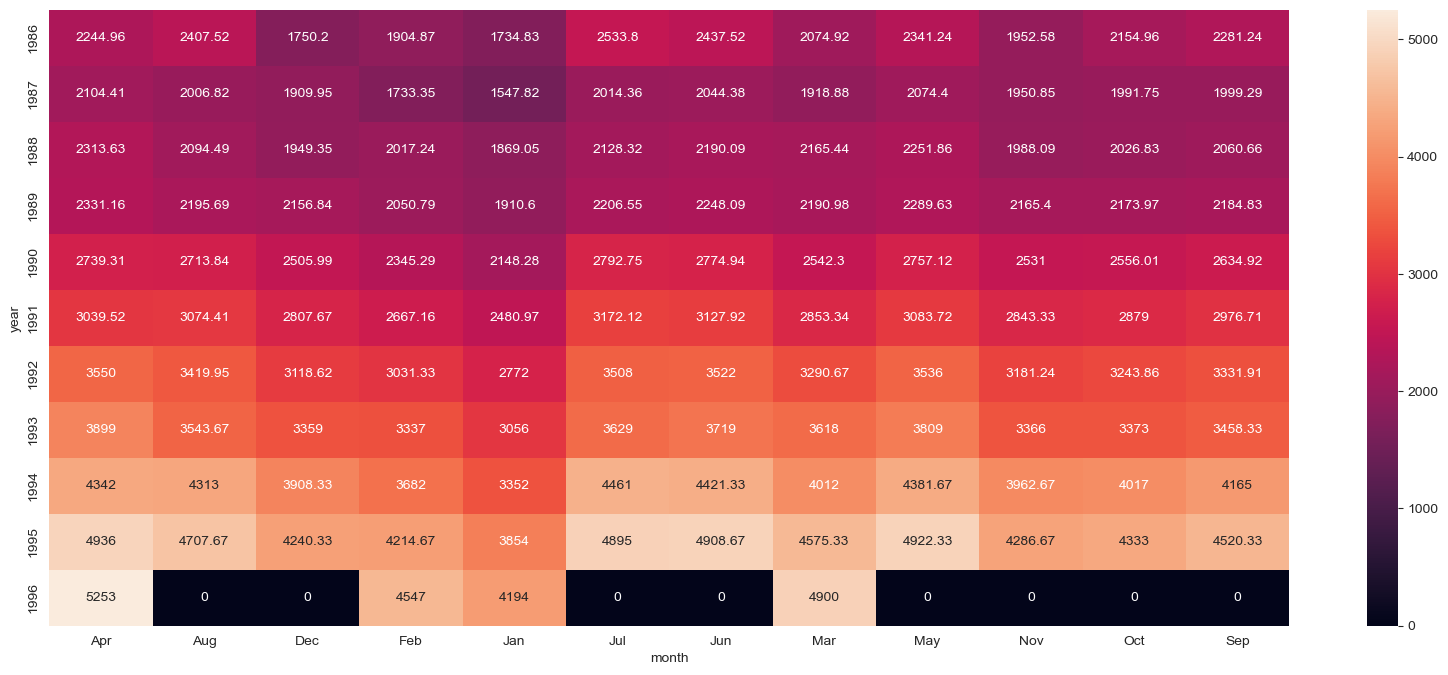

In [119]:
plt.figure(figsize=(20,8))
heatmap_y_month = pd.pivot_table(data=cocacola,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

In [120]:
size = 100

train_data = cocacola.iloc[:size]
test_data = cocacola.iloc[size:]

In [121]:
train_data

Date        Sales    t  t_squared month  year    Jan    Feb    Mar  \
0  1986-01-31  1734.827000    1          1   Jan  1986   True  False  False   
1  1986-02-28  1904.871666    2          4   Feb  1986  False   True  False   
2  1986-03-31  2074.916332    3          9   Mar  1986  False  False   True   
3  1986-04-30  2244.960999    4         16   Apr  1986  False  False  False   
4  1986-05-31  2341.242330    5         25   May  1986  False  False  False   
..        ...          ...  ...        ...   ...   ...    ...    ...    ...   
95 1993-12-31  3359.000000   96       9216   Dec  1993  False  False  False   
96 1994-01-31  3352.000000   97       9409   Jan  1994   True  False  False   
97 1994-02-28  3682.000000   98       9604   Feb  1994  False   True  False   
98 1994-03-31  4012.000000   99       9801   Mar  1994  False  False   True   
99 1994-04-30  4342.000000  100      10000   Apr  1994  False  False  False   

      Apr    May    Jun    Jul    Aug    Sep    Oct    Nov    Dec  log_sales  
0   False  False  False  False  False  False  False  False  False   7.458663  
1   False  False  False  False  False  False  False  False  False   7.552170  
2   False  False  False  False  False  False  False  False  False   7.637676  
3    True  False  False  False  False  False  False  False  False   7.716443  
4   False   True  False  False  False  False  False  False  False   7.758437  
..    ...    ...    ...    ...    ...    ...    ...    ...    ...        ...  
95  False  False  False  False  False  False  False  False   True   8.119399  
96  False  False  False  False  False  False  False  False  False   8.117312  
97  False  False  False  False  False  False  False  False  False   8.211211  
98  False  False  False  False  False  False  False  False  False   8.297045  
99   True  False  False  False  False  False  False  False  False   8.376090  

[100 rows x 19 columns]

In [122]:
test_data

Date        Sales    t  t_squared month  year    Jan    Feb    Mar  \
100 1994-05-31  4381.666667  101      10201   May  1994  False  False  False   
101 1994-06-30  4421.333333  102      10404   Jun  1994  False  False  False   
102 1994-07-31  4461.000000  103      10609   Jul  1994  False  False  False   
103 1994-08-31  4313.000000  104      10816   Aug  1994  False  False  False   
104 1994-09-30  4165.000000  105      11025   Sep  1994  False  False  False   
105 1994-10-31  4017.000000  106      11236   Oct  1994  False  False  False   
106 1994-11-30  3962.666667  107      11449   Nov  1994  False  False  False   
107 1994-12-31  3908.333333  108      11664   Dec  1994  False  False  False   
108 1995-01-31  3854.000000  109      11881   Jan  1995   True  False  False   
109 1995-02-28  4214.666667  110      12100   Feb  1995  False   True  False   
110 1995-03-31  4575.333333  111      12321   Mar  1995  False  False   True   
111 1995-04-30  4936.000000  112      12544   Apr  1995  False  False  False   
112 1995-05-31  4922.333333  113      12769   May  1995  False  False  False   
113 1995-06-30  4908.666667  114      12996   Jun  1995  False  False  False   
114 1995-07-31  4895.000000  115      13225   Jul  1995  False  False  False   
115 1995-08-31  4707.666667  116      13456   Aug  1995  False  False  False   
116 1995-09-30  4520.333333  117      13689   Sep  1995  False  False  False   
117 1995-10-31  4333.000000  118      13924   Oct  1995  False  False  False   
118 1995-11-30  4286.666667  119      14161   Nov  1995  False  False  False   
119 1995-12-31  4240.333333  120      14400   Dec  1995  False  False  False   
120 1996-01-31  4194.000000  121      14641   Jan  1996   True  False  False   
121 1996-02-29  4547.000000  122      14884   Feb  1996  False   True  False   
122 1996-03-31  4900.000000  123      15129   Mar  1996  False  False   True   
123 1996-04-30  5253.000000  124      15376   Apr  1996  False  False  False   

       Apr    May    Jun    Jul    Aug    Sep    Oct    Nov    Dec  log_sales  
100  False   True  False  False  False  False  False  False  False   8.385184  
101  False  False   True  False  False  False  False  False  False   8.394197  
102  False  False  False   True  False  False  False  False  False   8.403128  
103  False  False  False  False   True  False  False  False  False   8.369389  
104  False  False  False  False  False   True  False  False  False   8.334472  
105  False  False  False  False  False  False   True  False  False   8.298291  
106  False  False  False  False  False  False  False   True  False   8.284672  
107  False  False  False  False  False  False  False  False   True   8.270866  
108  False  False  False  False  False  False  False  False  False   8.256867  
109  False  False  False  False  False  False  False  False  False   8.346326  
110  False  False  False  False  False  False  False  False  False   8.428435  
111   True  False  False  False  False  False  False  False  False   8.504311  
112  False   True  False  False  False  False  False  False  False   8.501538  
113  False  False   True  False  False  False  False  False  False   8.498758  
114  False  False  False   True  False  False  False  False  False   8.495970  
115  False  False  False  False   True  False  False  False  False   8.456948  
116  False  False  False  False  False   True  False  False  False   8.416341  
117  False  False  False  False  False  False   True  False  False   8.374015  
118  False  False  False  False  False  False  False   True  False   8.363265  
119  False  False  False  False  False  False  False  False   True   8.352397  
120  False  False  False  False  False  False  False  False  False   8.341410  
121  False  False  False  False  False  False  False  False  False   8.422223  
122  False  False  False  False  False  False  False  False  False   8.496990  
123   True  False  False  False  False  False  False  False  False   8.566555

Building Ordinary Square Model (Linear Model)

In [123]:
#Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('Sales~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_linear))**2))
rmse_linear

686.8740863668938

In [124]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     397.1
Date:                Wed, 01 Nov 2023   Prob (F-statistic):           3.03e-36
Time:                        19:49:20   Log-Likelihood:                -705.92
No. Observations:                 100   AIC:                             1416.
Df Residuals:                      98   BIC:                             1421.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1642.3384     57.309     28.658      0.000    1528.611    1756.065
t             19.6334      0.985     19.928      0.000      17.678      21.589
==============================================================================
Omnibus:                        7.535   Durbin-Watson:                   0.203
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.789
Skew:                           0.683   Prob(JB):                       0.0204
Kurtosis:                       2.929   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
#Exponential

Exp = smf.ols('log_sales~t',data=train_data).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test_data['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

530.3268025099107

In [126]:
Exp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     406.5
Date:                Wed, 01 Nov 2023   Prob (F-statistic):           1.20e-36
Time:                        19:49:45   Log-Likelihood:                 84.607
No. Observations:                 100   AIC:                            -165.2
Df Residuals:                      98   BIC:                            -160.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4782      0.021    353.829      0.000       7.436       7.520
t              0.0073      0.000     20.162      0.000       0.007       0.008
==============================================================================
Omnibus:                        6.147   Durbin-Watson:                   0.225
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                5.627
Skew:                           0.561   Prob(JB):                       0.0600
Kurtosis:                       3.301   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [127]:
#Quadratic 

Quad = smf.ols('Sales~t+t_squared',data=train_data).fit()
pred_Quad = pd.Series(Quad.predict(test_data[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

371.29418344986567

In [128]:
Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     325.2
Date:                Wed, 01 Nov 2023   Prob (F-statistic):           9.85e-44
Time:                        19:50:10   Log-Likelihood:                -684.82
No. Observations:                 100   AIC:                             1376.
Df Residuals:                      97   BIC:                             1383.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2022.9480     70.858     28.549      0.000    1882.314    2163.582
t             -2.7554      3.238     -0.851      0.397      -9.183       3.672
t_squared      0.2217      0.031      7.136      0.000       0.160       0.283
==============================================================================
Omnibus:                        3.492   Durbin-Watson:                   0.306
Prob(Omnibus):                  0.174   Jarque-Bera (JB):                2.371
Skew:                           0.193   Prob(JB):                        0.306
Kurtosis:                       2.352   Cond. No.                     1.39e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [129]:
#Additive seasonality 

add_sea = smf.ols('Sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1837.7879723483788

In [130]:
add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                 -0.044
Method:                 Least Squares   F-statistic:                    0.6210
Date:                Wed, 01 Nov 2023   Prob (F-statistic):              0.806
Time:                        19:50:40   Log-Likelihood:                -783.17
No. Observations:                 100   AIC:                             1590.
Df Residuals:                      88   BIC:                             1622.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2431.1678     60.077     40.467      0.000    2311.777    2550.559
Jan[T.True]  -112.1065    208.114     -0.539      0.591    -525.689     301.476
Feb[T.True]    98.7249    208.114      0.474      0.636    -314.858     512.308
Mar[T.True]   309.5564    208.114      1.487      0.140    -104.026     723.139
Apr[T.True]   520.3878    208.114      2.500      0.014     106.805     933.971
May[T.True]   336.7034    219.714      1.532      0.129     -99.932     773.339
Jun[T.True]   326.8245    219.714      1.488      0.140    -109.811     763.460
Jul[T.True]   316.9457    219.714      1.443      0.153    -119.690     753.581
Aug[T.True]   250.8819    219.714      1.142      0.257    -185.753     687.517
Sep[T.True]   184.8182    219.714      0.841      0.403    -251.817     621.453
Oct[T.True]   118.7544    219.714      0.540      0.590    -317.881     555.390
Nov[T.True]    66.1439    219.714      0.301      0.764    -370.491     502.779
Dec[T.True]    13.5333    219.714      0.062      0.951    -423.102     450.168
==============================================================================
Omnibus:                       30.612   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.038
Skew:                           0.459   Prob(JB):                       0.0109
Kurtosis:                       1.848   Cond. No.                     8.05e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.67e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [131]:
#Additive Seasonality Quadratic 

add_sea_Quad = smf.ols('Sales~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

225.80498810301293

In [132]:
add_sea_Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     138.2
Date:                Wed, 01 Nov 2023   Prob (F-statistic):           8.95e-52
Time:                        19:51:01   Log-Likelihood:                -632.59
No. Observations:                 100   AIC:                             1293.
Df Residuals:                      86   BIC:                             1330.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1865.7939     41.512     44.946      0.000    1783.271    1948.316
Jan[T.True]  -159.7690     46.717     -3.420      0.001    -252.640     -66.898
Feb[T.True]    31.7000     46.733      0.678      0.499     -61.202     124.602
Mar[T.True]   222.7184     46.754      4.764      0.000     129.774     315.663
Apr[T.True]   413.2862     46.781      8.834      0.000     320.288     506.284
May[T.True]   372.3785     49.451      7.530      0.000     274.074     470.683
Jun[T.True]   344.0384     49.465      6.955      0.000     245.706     442.371
Jul[T.True]   315.2478     49.481      6.371      0.000     216.884     413.612
Aug[T.True]   229.8216     49.499      4.643      0.000     131.421     328.222
Sep[T.True]   143.9448     49.519      2.907      0.005      45.505     242.385
Oct[T.True]    57.6174     49.541      1.163      0.248     -40.867     156.102
Nov[T.True]   -15.7075     49.565     -0.317      0.752    -114.240      82.825
Dec[T.True]   -89.4829     49.592     -1.804      0.075    -188.068       9.102
t              -2.9439      2.056     -1.432      0.156      -7.032       1.144
t_squared       0.2253      0.020     11.418      0.000       0.186       0.265
==============================================================================
Omnibus:                        0.473   Durbin-Watson:                   0.152
Prob(Omnibus):                  0.789   Jarque-Bera (JB):                0.611
Skew:                          -0.001   Prob(JB):                        0.737
Kurtosis:                       2.617   Cond. No.                     9.72e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.17e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [133]:
##Multiplicative Seasonality

Mul_sea = smf.ols('log_sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test_data))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

1904.794417192032

In [134]:
Mul_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                    0.6657
Date:                Wed, 01 Nov 2023   Prob (F-statistic):              0.767
Time:                        19:51:22   Log-Likelihood:                 6.6723
No. Observations:                 100   AIC:                             10.66
Df Residuals:                      88   BIC:                             41.92
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.2447      0.022    324.766      0.000       7.200       7.289
Jan[T.True]     0.4719      0.077      6.107      0.000       0.318       0.626
Feb[T.True]     0.5592      0.077      7.236      0.000       0.406       0.713
Mar[T.True]     0.6393      0.077      8.273      0.000       0.486       0.793
Apr[T.True]     0.7134      0.077      9.232      0.000       0.560       0.867
May[T.True]     0.6582      0.082      8.068      0.000       0.496       0.820
Jun[T.True]     0.6547      0.082      8.025      0.000       0.493       0.817
Jul[T.True]     0.6508      0.082      7.977      0.000       0.489       0.813
Aug[T.True]     0.6277      0.082      7.694      0.000       0.466       0.790
Sep[T.True]     0.6038      0.082      7.401      0.000       0.442       0.766
Oct[T.True]     0.5791      0.082      7.098      0.000       0.417       0.741
Nov[T.True]     0.5558      0.082      6.812      0.000       0.394       0.718
Dec[T.True]     0.5309      0.082      6.508      0.000       0.369       0.693
==============================================================================
Omnibus:                       74.329   Durbin-Watson:                   0.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.756
Skew:                           0.261   Prob(JB):                       0.0125
Kurtosis:                       1.648   Cond. No.                     8.05e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.67e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [135]:
#Multiplicative Additive Seasonality 

Mul_Add_sea = smf.ols('log_sales~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test_data))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

396.4197817382147

In [136]:
Mul_Add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     61.10
Date:                Wed, 01 Nov 2023   Prob (F-statistic):           4.29e-37
Time:                        19:51:47   Log-Likelihood:                 114.86
No. Observations:                 100   AIC:                            -203.7
Df Residuals:                      87   BIC:                            -169.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.9000      0.015    450.015      0.000       6.870       6.931
Jan[T.True]     0.4543      0.026     17.240      0.000       0.402       0.507
Feb[T.True]     0.5342      0.026     20.263      0.000       0.482       0.587
Mar[T.True]     0.6069      0.026     23.011      0.000       0.554       0.659
Apr[T.True]     0.6736      0.026     25.526      0.000       0.621       0.726
May[T.True]     0.6553      0.028     23.563      0.000       0.600       0.711
Jun[T.True]     0.6445      0.028     23.171      0.000       0.589       0.700
Jul[T.True]     0.6332      0.028     22.759      0.000       0.578       0.688
Aug[T.True]     0.6027      0.028     21.656      0.000       0.547       0.658
Sep[T.True]     0.5714      0.028     20.523      0.000       0.516       0.627
Oct[T.True]     0.5392      0.028     19.360      0.000       0.484       0.595
Nov[T.True]     0.5085      0.028     18.246      0.000       0.453       0.564
Dec[T.True]     0.4763      0.028     17.077      0.000       0.421       0.532
t               0.0074      0.000     25.888      0.000       0.007       0.008
==============================================================================
Omnibus:                       14.672   Durbin-Watson:                   0.081
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.352
Skew:                           0.801   Prob(JB):                     0.000171
Kurtosis:                       4.264   Cond. No.                     4.13e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.98e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [137]:
#Compare the results 

data = {"Models":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

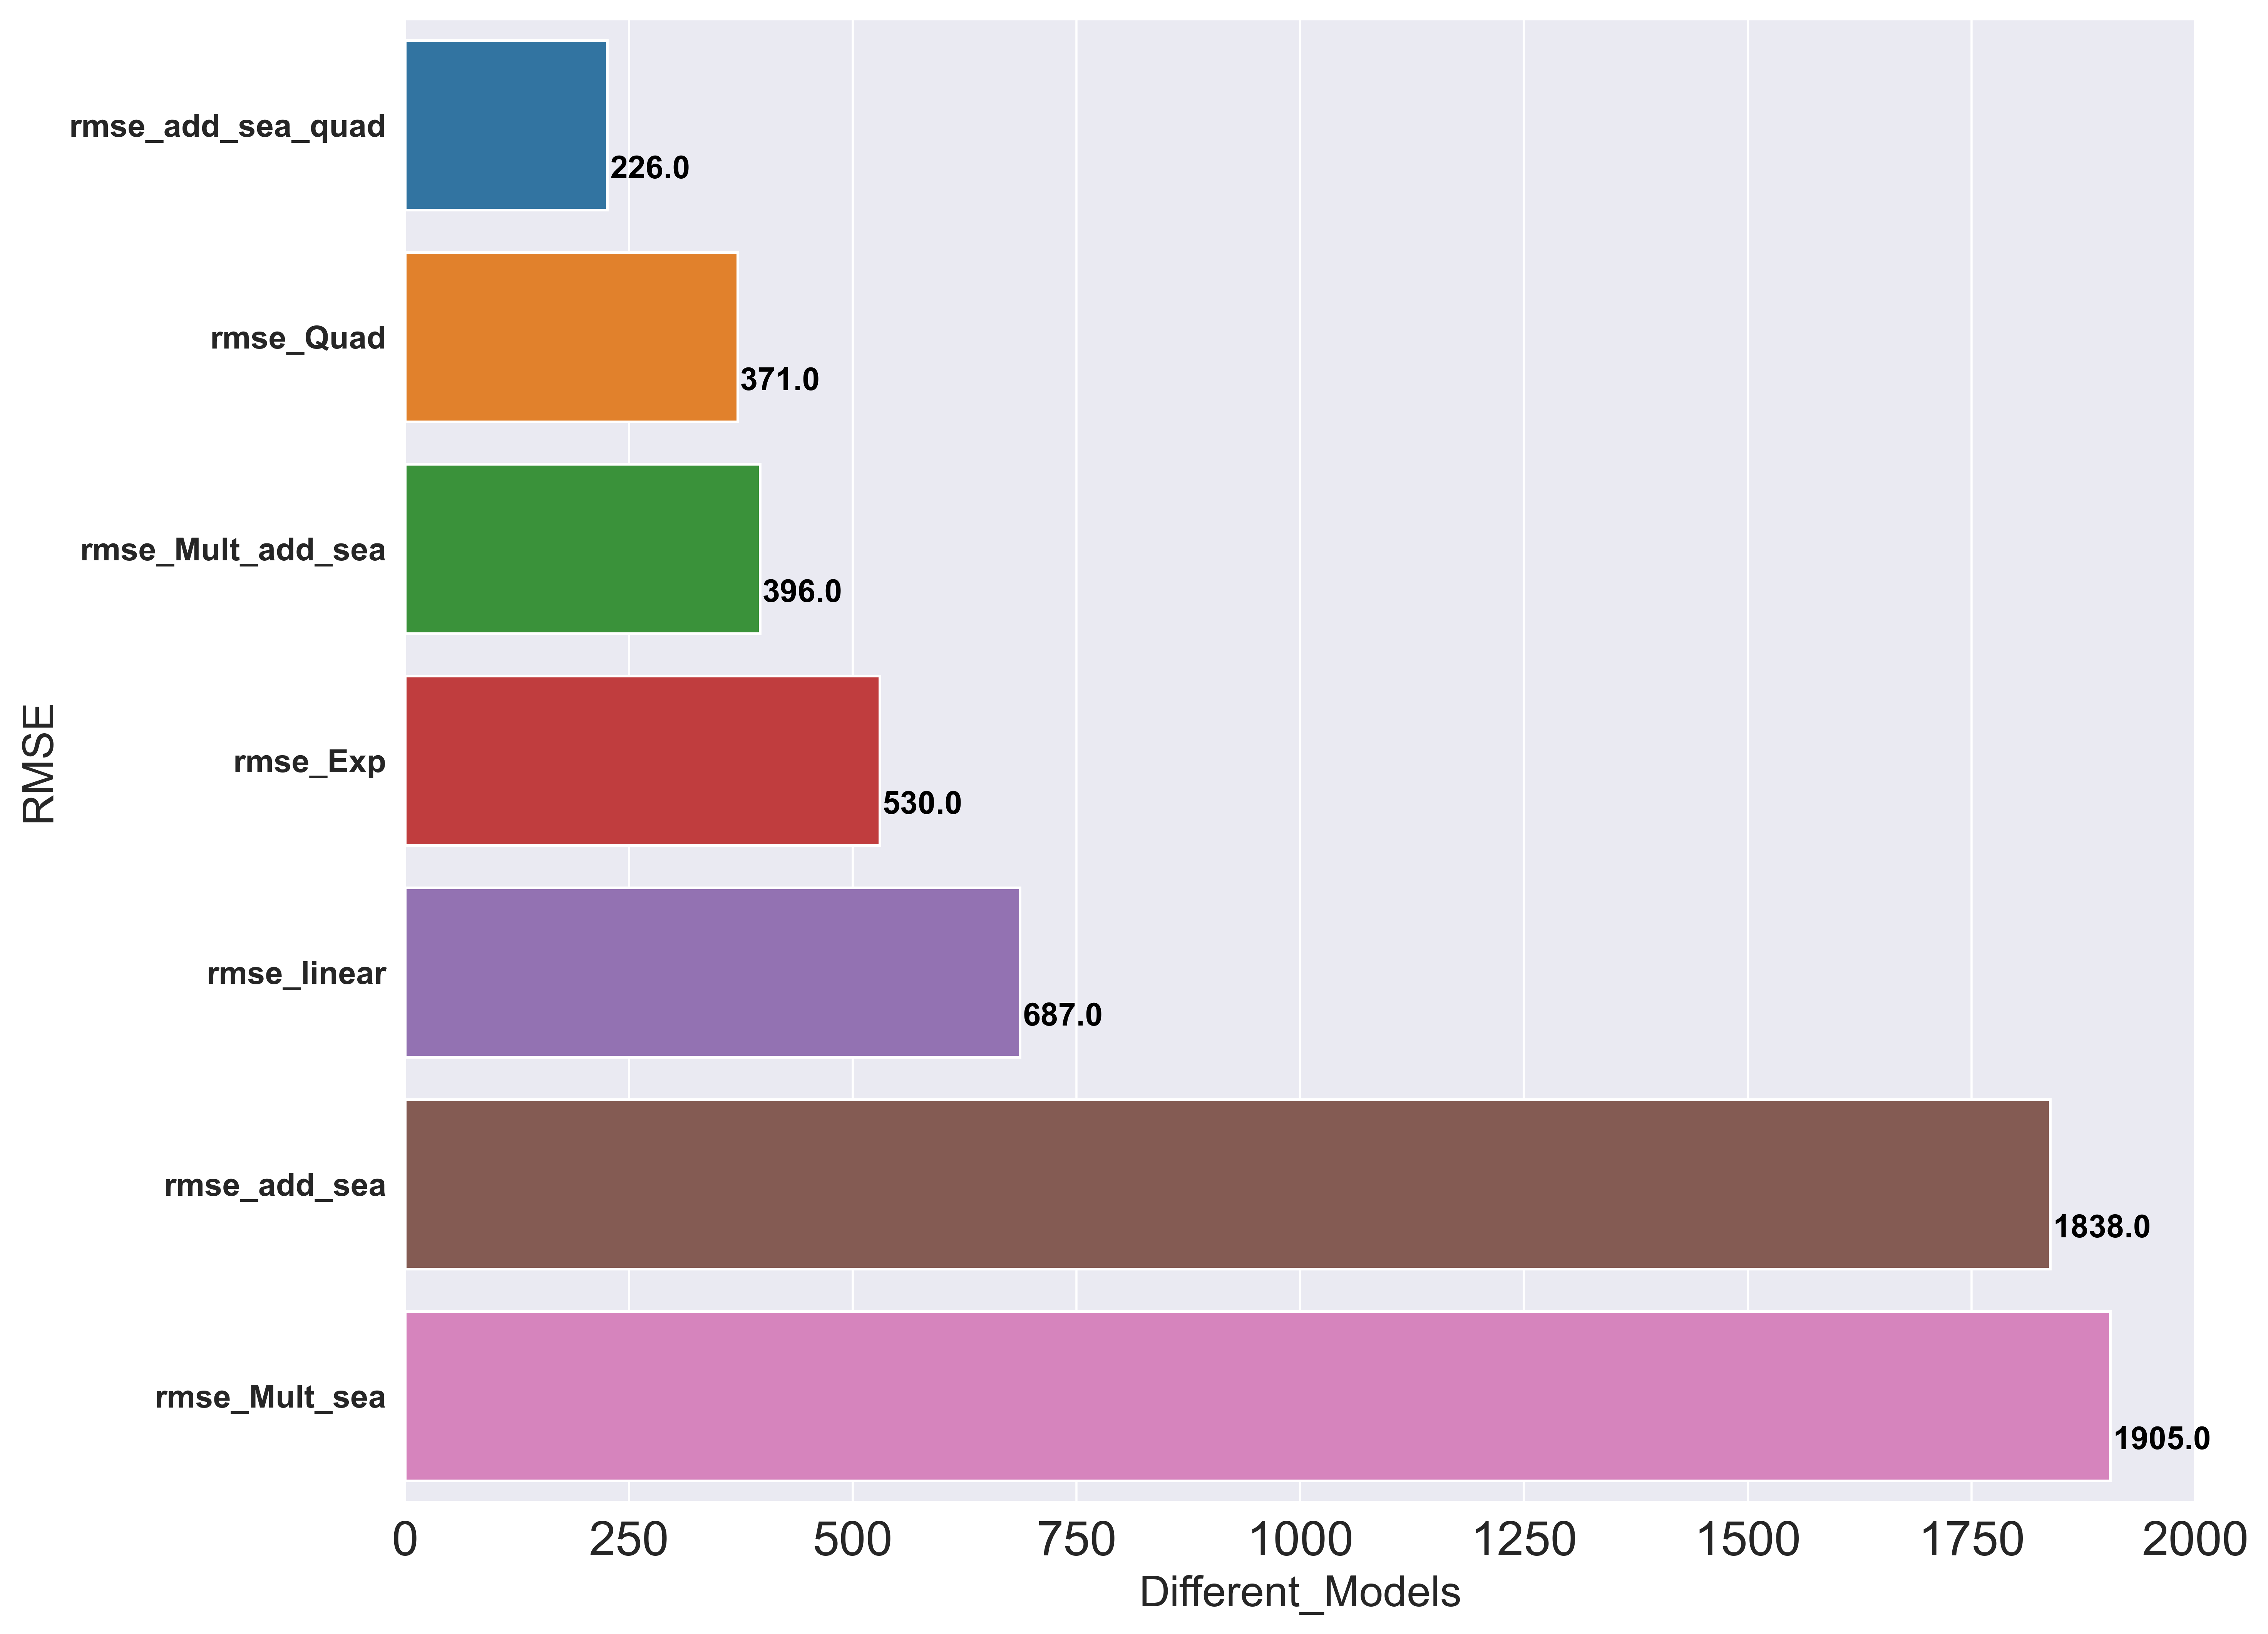

In [138]:
e=table_rmse
f, axe = plt.subplots(1,1, figsize=(12,10), dpi=500)
sns.barplot(x='RMSE_Values', y='Models', data=e, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=18)

for i, v in enumerate(np.round(e.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v),
            color = 'black', fontweight = 'bold', fontsize= 12)

plt.show()